In this notebook I run a deep learning models then compare the results to dummy models and looks closely at false positives and predictions.

In [1]:
from path import Path
import arrow
import json
import pytz
from pprint import pprint
from tqdm.notebook import tqdm
import re, os, collections, itertools, uuid, logging
import tempfile
import zipfile
import urllib
import ee
import pyproj
import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import seaborn as sns
import shapely

%matplotlib inline
# %precision 4
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6) # bigger plots
sns.set_palette("Set2", 10)

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES']="" # to disable gpu, so I can do large predictions in memory

In [3]:
import keras
import tensorflow
import sklearn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape, InputLayer, Permute, RepeatVector, Dropout, LocallyConnected1D
from keras.layers.core import Activation
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import UpSampling1D
from keras.layers.convolutional import Convolution1D, MaxPooling1D, MaxPooling2D
from keras.layers.core import Flatten
from tensorflow.keras.optimizers import SGD
from keras.datasets import mnist
from tensorflow.keras.layers import (Input, LocallyConnected1D, ZeroPadding1D, Cropping1D, Embedding, 
    Cropping2D, Convolution1D, Convolution2D, BatchNormalization, UpSampling1D, RepeatVector)
# Merge, merge, Deconvolution2D, activations
from keras.layers import embeddings, convolutional, normalization, advanced_activations, ZeroPadding2D, UpSampling2D
from keras.models import Model
from keras_tqdm import TQDMCallback, TQDMNotebookCallback

In [4]:
# helper_dir = str(Path('.').abspath())
# if helper_dir not in os.sys.path:
#     os.sys.path.append(helper_dir)

from leak_helpers.earth_engine import display_ee, get_boundary, tifs2np, bands_s2, bands_s2_l2a, bands_s2_l2a_dem, download_image, bands_s1, bands_s1_float, bands_s1_float_dem, bands_l7, bands_l8, bands_srtm
from leak_helpers.geometry import diffxy, resample_polygon
from leak_helpers.modelling import ImageDataGenerator, dice_coef_loss
from leak_helpers.visualization import imshow_bands
from leak_helpers.analysis import  calculate_result_class, find_best_dummy_classification, parse_classification_report
from leak_helpers.modelling.filters import is_not_cloudy, is_not_center_cloudy, is_image_within, is_leak, filter_split_data, normalise_bands

In [5]:
# # Non voglio stampare i Warning
# import warnings
# warnings.filterwarnings("ignore")

In [6]:
keras.__version__, tensorflow.__version__

('2.7.0', '2.7.0')

In [7]:
# params
data_paths = [
    Path('../data/scraped_satellite_images/COPERNICUS_S1_GRD'),
    #Path('../data/scraped_satellite_images/COPERNICUS_S1_GRD_FLOAT'),
    #Path('../data/scraped_satellite_images/COPERNICUS_S2'),
    #Path('../data/scraped_satellite_images/COPERNICUS_S2_SR'),
    #Path('../data/scraped_satellite_images/LANDSAT_LE7_L1T'),
    #Path('../data/scraped_satellite_images/LANDSAT_LC8_L1T'),
    #Path('../data/scraped_satellite_images/USDA_NAIP_DOQQ'),
    #Path('../data/scraped_satellite_images/USGS_SRTMGL1_003'),
]

data_path = data_paths[0]
data_path

notebook_name = 'leak_detection_CNN'
batch_size=128*2 # ideally it's 300-600 so the mean is similar to the global mean, but gpu mem is limited
random_seed = 1337
test_fraction = 0.2
# max_cloud_cover = 0.10 # cloud cover must less than this
thresh = 0.5 # balance precision vs recall
balanced_classes = True
normalized = True
# filter_center_cloudy = False

# derived
outdir = Path('../output').joinpath(notebook_name).joinpath(os.path.split(data_path)[-1])
outdir.makedirs_p()
outdir

Path('../output\\leak_detection_CNN\\COPERNICUS_S1_GRD')

In [8]:
script_metadata = json.load(open(data_path.joinpath('script_metadata.json')))
bands = script_metadata['bands']

# test load
import h5py
metadatas = json.load(open(data_path.joinpath('data_metadata.json')))
with h5py.File(data_path.joinpath('data.h5'),'r') as h5f:
    X_raw = h5f['X'][:]
    y_raw = h5f['y'][:]

X_raw = X_raw.astype('float64')

print(X_raw.shape,'\n', y_raw[:10],'\n', metadatas[0].keys(),'\n', data_path)
data_detail = []
for b in range(X_raw.shape[1]):
    data_detail.append([bands[b],X_raw[:,b].min(),X_raw[:,b].max(), np.count_nonzero(X_raw[:,b])])

data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
print(data_detail)

(2568, 3, 25, 25) 
 [False  True False False  True  True False  True False False] 
 dict_keys(['image', 'scale', 'crs', 'name', 'distance', 'leak']) 
 ../data/scraped_satellite_images/COPERNICUS_S1_GRD
   Banda        Min        Max  Non Zero
0     VV -36.043572  35.034283   1603636
1     VH -47.707378  13.539669   1603636
2  angle  34.206566  39.647694   1605000


In [9]:
### Filtro il dataset per le sole bande che mi interessano
dem_bands = False

if os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD' and dem_bands == True:
    # satellite Sentinel-1 SAR
    # filtro l'input in modo che prenda solo le bande VV e VH
    best_bands = [bands.index('VV'),bands.index('VH'),
                  #bands.index('angle'), 
                  bands.index('elevation'),bands.index('slope'), 
                 ]
elif os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD' and dem_bands == False:
    best_bands = [bands.index('VV'),bands.index('VH'),
                  #bands.index('angle'), 
                 ]
elif os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD_FLOAT' and dem_bands == True:
    # satellite Sentinel-1 SAR non log con change detection
    best_bands = [bands.index('VV_num'), bands.index('VH_num'), #bands.index('angle_num'),
     bands.index('VV_den'), bands.index('VH_den'), #bands.index('angle_den'),
     bands.index('VV/VV'), bands.index('VH/VH'), #bands.index('angle/angle'),
     bands.index('m2logq'), bands.index('prob'), bands.index('cmap'), 
     bands.index('elevation'), bands.index('slope'), 
                 ]
elif os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD_FLOAT' and dem_bands == False:
    best_bands = [bands.index('VV_num'), bands.index('VH_num'), #bands.index('angle_num'),
     bands.index('VV_den'), bands.index('VH_den'), #bands.index('angle_den'),
     bands.index('VV/VV'), bands.index('VH/VH'), #bands.index('angle/angle'),
     bands.index('m2logq'), bands.index('prob'), bands.index('cmap'), 
                 ]
elif os.path.split(data_path)[-1] == 'COPERNICUS_S2':
    # satellite Sentinel-2 RGB + NIR + IR
    # B2: Blue, B3: Green, B4: Red, B8: Near InfraRed, B11: ShortWawe IR 1, B12: ShortWawe IR 2
    best_bands = [bands.index('B2'),bands.index('B3'),bands.index('B4'), # BGR
                  bands.index('B5'),bands.index('B6'),bands.index('B7'), # Vegetation Red Edge
                  bands.index('B8'),bands.index('B8A'),bands.index('B11'),bands.index('B12'), #NIR Vegetation Red Edge SWIR1 SWIR2
                 ]
elif os.path.split(data_path)[-1] == 'COPERNICUS_S2_SR' and dem_bands == True:
    # satellite Sentinel-2 RGB + NIR + IR
    # B2: Blue, B3: Green, B4: Red, B8: Near InfraRed, B11: ShortWawe IR 1, B12: ShortWawe IR 2
    best_bands = [bands.index('B2'),bands.index('B3'),bands.index('B4'), # BGR
                  bands.index('B5'),bands.index('B6'),bands.index('B7'), # Vegetation Red Edge
                  bands.index('B8'),bands.index('B8A'),bands.index('B11'),bands.index('B12'), #NIR Vegetation Red Edge SWIR1 SWIR2
                  bands.index('elevation'),bands.index('slope'), 
                 ]
elif os.path.split(data_path)[-1] == 'COPERNICUS_S2_SR' and dem_bands == False:
    best_bands = [bands.index('B2'),bands.index('B3'),bands.index('B4'), # BGR
                  bands.index('B5'),bands.index('B6'),bands.index('B7'), # Vegetation Red Edge
                  bands.index('B8'),bands.index('B8A'),bands.index('B11'),bands.index('B12'), #NIR Vegetation Red Edge SWIR1 SWIR2
                 ]
else:
    best_bands = [x for x in range(len(bands))]

print("Id Bands:",best_bands)

X_raw = X_raw[:,[b for b in best_bands]] 
## riduce l'intera dimensione del dataset alle sole bande scelte

print(X_raw.shape)
data_detail = []
for b in range(X_raw.shape[1]):
    data_detail.append([bands[best_bands[b]],X_raw[:,b].min(),X_raw[:,b].max(), np.count_nonzero(X_raw[:,b])])

data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
print(data_detail)

Id Bands: [0, 1]
(2568, 2, 25, 25)
  Banda        Min        Max  Non Zero
0    VV -36.043572  35.034283   1603636
1    VH -47.707378  13.539669   1603636


In [10]:
####### Faccio il logaritmo delle bande del Sentinel-1
####### Estraggo solo il metadata['after']
if os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD_FLOAT':
    for b, i in enumerate(best_bands):
        if bands[i] not in ['m2logq','prob','cmap','elevation','slope']:
            X_raw[:,b,:,:] = 10*np.log(X_raw[:,b,:,:])
    
    metadata_after = [] 
    [ metadata_after.append(m['after']) for m in metadatas ]
    metadatas = metadata_after

    print(X_raw.shape)
    data_detail = []
    for b in range(X_raw.shape[1]):
        data_detail.append([bands[best_bands[b]],X_raw[:,b].min(),X_raw[:,b].max(), np.count_nonzero(X_raw[:,b])])

    data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
    print(data_detail)

VV


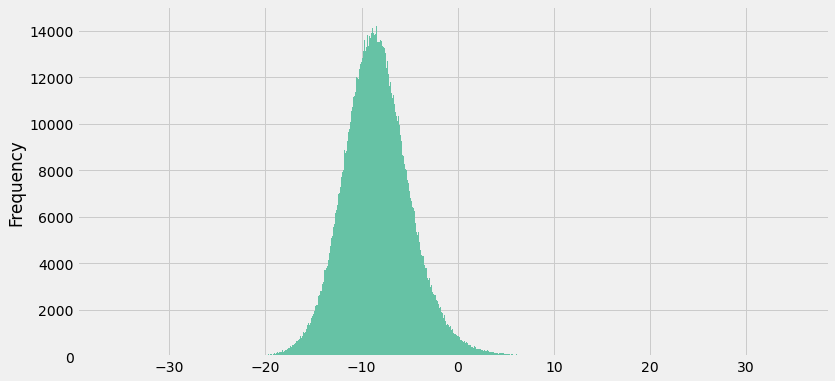

VH


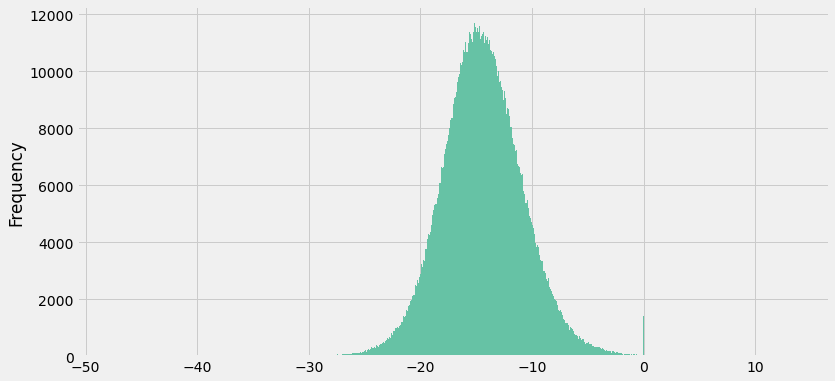

In [11]:
# Valuto la distribuzione
for b in range(X_raw.shape[1]):
    print(bands[best_bands[b]])
    pd.Series(X_raw[:,b].flatten()).plot.hist(bins=1000)
    plt.show()

In [12]:
#### Cambio la forma dei dati di INPUT così da avere il canale in fondo
X_temp = np.zeros((X_raw.shape[0],25,25,X_raw.shape[1]))
y_temp = y_raw
m_temp = metadatas

for i, img in enumerate(X_raw):
    for b, img_b in enumerate(img):
        X_temp[i,:,:,b] = img_b

print(X_temp.shape)
data_detail = []
for b in range(X_temp.shape[3]):
    data_detail.append([bands[best_bands[b]],X_temp[:,:,:,b].min(),X_temp[:,:,:,b].max(), np.count_nonzero(X_temp[:,:,:,b])])

data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
print(data_detail)

(2568, 25, 25, 2)
  Banda        Min        Max  Non Zero
0    VV -36.043572  35.034283   1603636
1    VH -47.707378  13.539669   1603636


In [13]:
####### Filtro le perdite avvenute d'estate se Sentinel-2
month_filter = False
mesi = [6,7,8]

if month_filter==True and os.path.split(data_path)[-1] in ('COPERNICUS_S2','COPERNICUS_S2_SR'):
    X_summer = []
    y_summer = []
    m_summer = []

    for i in range(len(metadatas)):
        ###t_sat = arrow.get(metadatas[i]['image']['properties']['system:time_start']/1000)
        #n_orb = metadatas[i]['image']['properties']['relativeOrbitNumber_start'] #Sentinel-1
        t_wo = arrow.get(metadatas[i]['leak']['features'][0]['properties']['reportdate'])
        m = t_wo.month
        if m in mesi:
            X_summer.append(X_temp[i])
            y_summer.append(y_temp[i])
            m_summer.append(m_temp[i])

    #X_raw.shape, np.array(X_summer).shape
    X_temp = np.array(X_summer)
    y_temp = np.array(y_summer)
    m_temp = np.array(m_summer)

    print(X_temp.shape)
    data_detail = []
    for b in range(X_temp.shape[3]):
        data_detail.append([bands[best_bands[b]],X_temp[:,:,:,b].min(),X_temp[:,:,:,b].max(), np.count_nonzero(X_temp[:,:,:,b])])

    data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
    print(data_detail)

In [14]:
if os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD_FLOAT':
    orbit_list = []
    for i in range(len(metadatas)):
        n_orb = metadatas[i]['image']['properties']['relativeOrbitNumber_start']
        t_orb = metadatas[i]['image']['properties']['orbitProperties_pass']
        orbit_list.append([n_orb, t_orb])

    orbit_df = pd.DataFrame(orbit_list, columns = ['n_orb','t_orb'])
    print(orbit_df.groupby(['n_orb','t_orb']).size())

In [15]:
# ####### Filtro le perdite di una certa orbita e tipo se Sentinel-1
orbit_number0 = 168 
orbit_type0 = 'ASCENDING' 

# if os.path.split(data_path)[-1]  == 'COPERNICUS_S1_GRD_FLOAT':
#     X_orbit = []
#     y_orbit = []
#     m_orbit = []

#     for i in range(len(metadatas)):
#         #t_sat = arrow.get(metadatas[i]['image']['properties']['system:time_start']/1000)
#         n_orb = metadatas[i]['image']['properties']['relativeOrbitNumber_start']
#         t_orb = metadatas[i]['image']['properties']['orbitProperties_pass']
#         if n_orb == orbit_number0 and t_orb == orbit_type0 :
#             X_orbit.append(X_temp[i])
#             y_orbit.append(y_temp[i])
#             m_orbit.append(m_temp[i])

#     #X_raw.shape, np.array(X_summer).shape
#     X_temp = np.array(X_orbit)
#     y_temp = np.array(y_orbit)
#     m_temp = np.array(m_orbit)

#     print(X_temp.shape)
#     data_detail = []
#     for b in range(X_temp.shape[3]):
#         data_detail.append([bands[best_bands[b]],X_temp[:,:,:,b].min(),X_temp[:,:,:,b].max(), np.count_nonzero(X_temp[:,:,:,b])])

#     data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
#     print(data_detail)

In [16]:
# ###### Normalizzo TUTTI i dati con media/stdev
# ########## normalizzo tutte le immagini catturate
norm_params = []

if normalized:
    for b, i in enumerate(best_bands):
        if bands[i] not in ['prob','cmap',]:
            norm_params.append([X_temp[:,:,:,b].mean(),X_temp[:,:,:,b].std()])
            X_temp[:,:,:,b] = (X_temp[:,:,:,b]-X_temp[:,:,:,b].mean())/(X_temp[:,:,:,b].std())

print(X_temp.shape)
data_detail = []
for b in range(X_temp.shape[-1]):
    data_detail.append([bands[best_bands[b]],X_temp[:,:,:,b].min(),X_temp[:,:,:,b].max(), np.count_nonzero(X_temp[:,:,:,b])])

data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
print(data_detail)
# norm_params

(2568, 25, 25, 2)
  Banda       Min        Max  Non Zero
0    VV -7.690239  12.062289   1605000
1    VH -8.948074   7.513325   1605000


VV


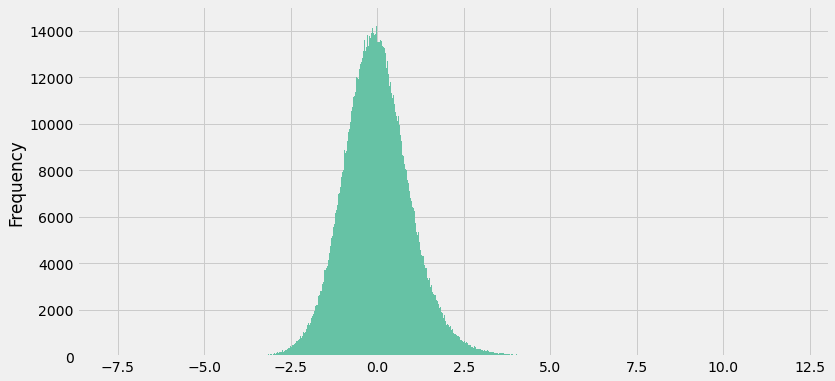

VH


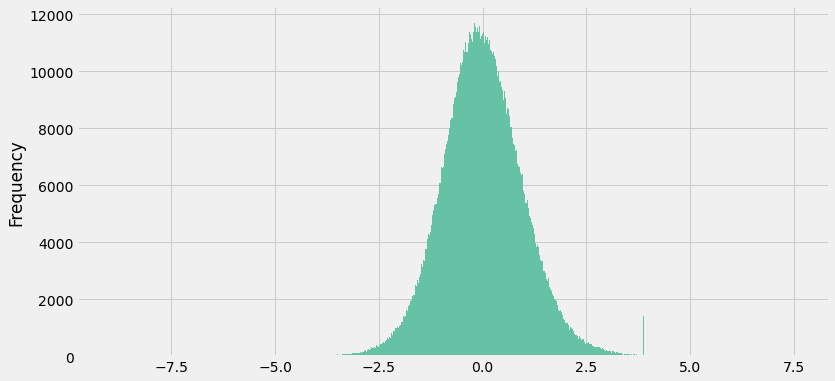

In [17]:
# Valuto la distribuzione
for b in range(X_temp.shape[-1]):
    print(bands[best_bands[b]])
    pd.Series(X_temp[:,:,:,b].flatten()).plot.hist(bins=1000)
    plt.show()

## Filter Data

In [18]:
# X_train, y_train, metadata_train, X_val, y_val, metadata_val, X_test, y_test, metadata_test = filter_split_data(
#     X_raw,
#     y_raw,
#     metadatas,
#     max_cloud_cover=max_cloud_cover,
#     #timespan_before=timespan_before,
#     test_fraction=test_fraction,
#     random_seed=random_seed,
#     balanced_classes=balanced_classes,
#     normalized=normalized,
#     filter_center_cloudy=False
# )  
# print((len(X_train)+len(X_test)+len(X_val))/len(X_raw))
# print(X_train.shape,y_train.shape, len(metadata_train))
# print(X_test.shape,y_test.shape, len(metadata_test))
# print(X_val.shape,y_val.shape, len(metadata_val))
# print(y_train.mean(),y_test.mean(),y_val.mean())

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, metadata_train, metadata_test = train_test_split(
    X_temp,
    y_temp,
    m_temp,
    test_size=0.3,
    random_state = 1234 )

X_val, X_test, y_val, y_test, metadata_val, metadata_test = train_test_split(
    X_test,
    y_test,
    metadata_test,
    test_size=0.5,
    random_state = 1234 )

print(len(X_train), len(y_train), len([i for i in y_train if i >= thresh]) )
print(len(X_test), len(y_test), len([i for i in y_test if i >= thresh]))
print(len(X_val), len(y_val), len([i for i in y_val if i >= thresh]))
print(len(metadata_train), len(metadata_test), len(metadata_val))

1797 1797 898
386 386 192
385 385 194
1797 386 385


In [20]:
##### Lista dei Risultati dei Modelli eseguiti
model_list = []
columns = ['model_name', 'aoc']

# Modelli Ensemble

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, auc

X_train_ensemble = X_train.reshape((len(X_train),-1))
X_val_ensemble = X_val.reshape((len(X_val),-1))
X_test_ensemble = X_test.reshape((len(X_test),-1))

target_names = ['no leak','leak']

# RandomForest

In [22]:
n_estimators_RF = [2,8,16,64,256,512,1024] # number of trees in the random forest
max_depth_RF = [None,10,20] # maximum number of levels allowed in each decision tree

cv_RF = 5
verbose_RF = 2

random_grid_RF = {'n_estimators': n_estimators_RF,
               'max_depth': max_depth_RF}

In [23]:
from sklearn.ensemble import RandomForestClassifier

hyperparam_RF = True

if hyperparam_RF:
    model_RF = RandomForestClassifier(n_jobs=12, verbose=verbose_RF)

    randomsearch_RF = GridSearchCV( estimator  = model_RF,
                       param_grid = random_grid_RF,
                       cv=cv_RF,
                       verbose= verbose_RF,
                       scoring='accuracy',
                       n_jobs=12)

    search_RF = randomsearch_RF.fit(X_train_ensemble, y_train)

    # summarize result
    print('Best Score: %s' % search_RF.best_score_)
    print('Best Hyperparameters: %s' % search_RF.best_params_)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
building tree 1 of 2
building tree 2 of 2
Best Score: 0.5024945837202104
Best Hyperparameters: {'max_depth': None, 'n_estimators': 2}


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   2 out of   2 | elapsed:    0.0s finished


In [24]:
try:
    bp_RF = search_RF.best_params_
except:
    if os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD':
        bp_RF = {'n_estimators': 2, 'max_depth': None} 
    elif os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD_FLOAT':
        bp_RF = {'n_estimators': 600, 'max_depth': 10} 
    elif os.path.split(data_path)[-1] == 'COPERNICUS_S2':
        bp_RF = {'n_estimators': 300, 'max_depth': 10}
    elif os.path.split(data_path)[-1] == 'COPERNICUS_S2_SR':
        bp_RF = {'n_estimators': 300, 'max_depth': 10}
        bp_RF = {'n_estimators': 2, 'max_depth': 10}

print(bp_RF)

{'max_depth': None, 'n_estimators': 2}


In [25]:
model_RF = RandomForestClassifier(**bp_RF, n_jobs=-1)
model_RF.fit(X_train_ensemble, y_train)

y_pred_RF = model_RF.predict(X_train_ensemble)
score = model_RF.score(X_train_ensemble, y_train)
report = pd.DataFrame(sklearn.metrics.classification_report(y_train>thresh,y_pred_RF>thresh,target_names=target_names, output_dict=True)).transpose()
cm = confusion_matrix(y_train, y_pred_RF, normalize = 'true')

print('Numero campioni:',len(X_train_ensemble))

print(report)
print(cm)

Numero campioni: 1797
              precision    recall  f1-score      support
no leak        0.746101  0.957731  0.838773   899.000000
leak           0.940902  0.673719  0.785204   898.000000
accuracy       0.815804  0.815804  0.815804     0.815804
macro avg      0.843501  0.815725  0.811988  1797.000000
weighted avg   0.843447  0.815804  0.812003  1797.000000
[[0.95773081 0.04226919]
 [0.32628062 0.67371938]]


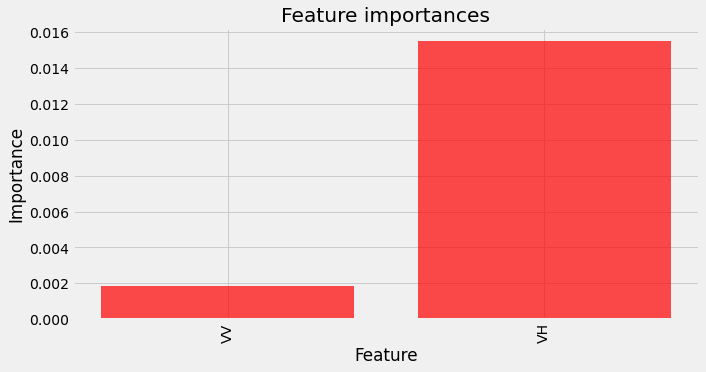

In [26]:
##### FEATURE IMPORTANCE Ensemble
##### n: controls the number of permutations per feature
model = model_RF
y_pred = model.predict_proba(X_test_ensemble)[:,1]

def get_feature_importance_ensemble(j, n):
    #### Uso la metrica AUC
    fpr , tpr , thresholds = roc_curve(y_test, y_pred) # baseline score
    s = auc(fpr, tpr)
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(X_test.shape[0]))
        X_test_ = X_test.copy()
        X_test_[:,:,:,j] = X_test[perm,:,:,j]
        X_test_ = X_test_.reshape((len(X_test_),-1))
        y_pred_ = model.predict_proba(X_test_)[:,1]
        fpr_ , tpr_ , thresholds_ = roc_curve ( y_test, y_pred_)
        s_ij = auc(fpr_, tpr_)
        total += s_ij
    return s - total / n


n_bands = X_test.shape[-1]
f = []
for j in range(n_bands) :
    f_j = get_feature_importance_ensemble(j, 10)
    f.append(f_j)# Plot

plt.figure(figsize=(10, 5))
plt.bar(range(n_bands), f, color="r", alpha=0.7)
plt.xticks(ticks=range(n_bands), labels=[bands[b] for b in best_bands], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

In [27]:
###### Dati Validazione
y_pred_RF = model_RF.predict(X_val_ensemble)
score = model_RF.score(X_val_ensemble, y_val)
report = pd.DataFrame(sklearn.metrics.classification_report(y_val>thresh,y_pred_RF>thresh,target_names=target_names, output_dict=True)).transpose()
cm = confusion_matrix(y_val, y_pred_RF, normalize = 'true')

print('Numero campioni:',len(X_val_ensemble))

print(report)
print(cm)

Numero campioni: 385
              precision    recall  f1-score     support
no leak        0.475524  0.712042  0.570231  191.000000
leak           0.444444  0.226804  0.300341  194.000000
accuracy       0.467532  0.467532  0.467532    0.467532
macro avg      0.459984  0.469423  0.435286  385.000000
weighted avg   0.459863  0.467532  0.434234  385.000000
[[0.71204188 0.28795812]
 [0.77319588 0.22680412]]


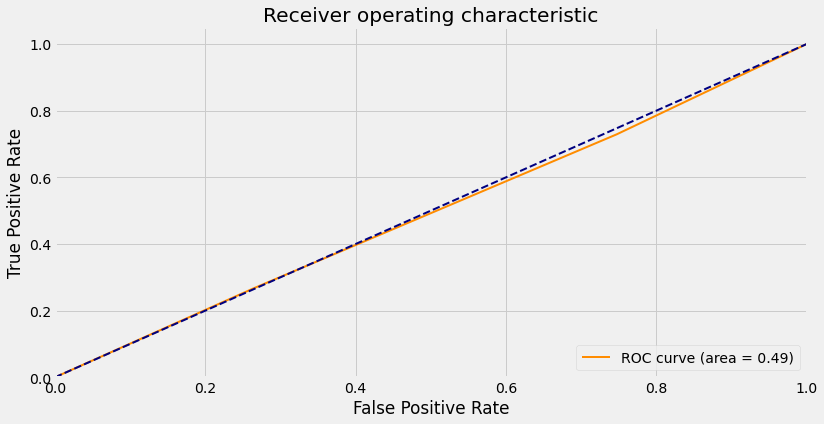

In [28]:
# Curva ROC test
y_pred_RF = model_RF.predict_proba(X_test_ensemble)[:,1]

fpr , tpr , thresholds = roc_curve ( y_test, y_pred_RF)
roc_auc = auc(fpr, tpr)
model_list.append(['model_RF',roc_auc])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

['no leak', 'leak']
[0.5 1.  0.5]
[ True False  True]


count    386.000000
mean       0.501295
std        0.363065
min        0.000000
25%        0.000000
50%        0.500000
75%        1.000000
max        1.000000
dtype: float64

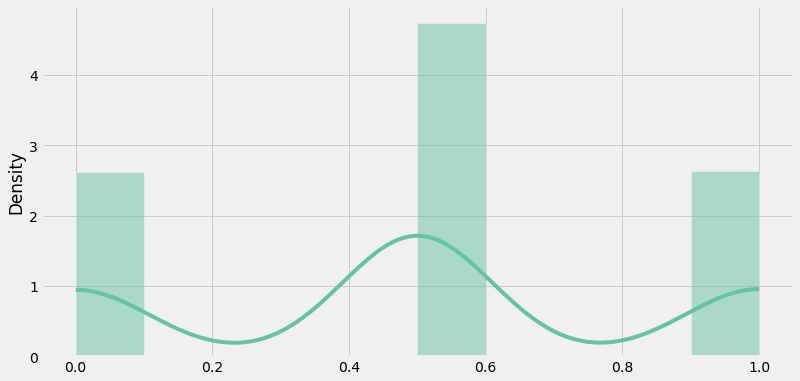

In [29]:
# Probabilità ['no leak','leak']
y_pred_RF = model_RF.predict_proba(X_test_ensemble)

print(target_names)
print(y_pred_RF[:,1][:3])
print(y_test[:3])

y_df = pd.Series(y_pred_RF[:,1])
sns.histplot(data=y_df,kde=True,stat="density")
y_df.describe()

In [30]:
# df_toplot = pd.DataFrame({'y_pred': y_pred_RF[:,1], 'mean_angle' : X_test[:,:,:,4].mean(axis=(1,2))})
# sns.scatterplot(data=df_toplot, x='y_pred', y='mean_angle')

# AdaBoost

In [31]:
n_estimators_AB = [6,8,12,16,20]
learning_rate_AB = [0.01,0.1,0.25]

cv_AB = 5
verbose_AB = 2

random_grid_AB = {'n_estimators': n_estimators_AB,
                 'learning_rate':learning_rate_AB}

In [32]:
from sklearn.ensemble import AdaBoostClassifier

hyperparam_AB = True

if hyperparam_AB:
    model_AB = AdaBoostClassifier()
    
    randomsearch_AB = GridSearchCV( estimator  = model_AB,
                       param_grid = random_grid_AB,
                       cv=cv_AB,
                       verbose= verbose_AB,
                       scoring='accuracy',
                       n_jobs=12)

    search_AB = randomsearch_AB.fit(X_train_ensemble, y_train)

    # summarize result
    print('Best Score: %s' % search_AB.best_score_)
    print('Best Hyperparameters: %s' % search_AB.best_params_)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Score: 0.4824775611265862
Best Hyperparameters: {'learning_rate': 0.01, 'n_estimators': 6}


In [33]:
try:
    bp_AB = search_AB.best_params_
except:
    if os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD':
        bp_AB = {'n_estimators': 6, 'learning_rate': 0.01}
    elif os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD_FLOAT':
        bp_AB = {'n_estimators': 16, 'learning_rate': 0.25}
    elif os.path.split(data_path)[-1] == 'COPERNICUS_S2':
        bp_AB = {'n_estimators': 16, 'learning_rate': 0.25}
    elif os.path.split(data_path)[-1] == 'COPERNICUS_S2_SR':
        bp_AB = {'n_estimators': 16, 'learning_rate': 0.25}
        bp_AB = {'n_estimators': 20, 'learning_rate': 0.1}

print(bp_AB)

{'learning_rate': 0.01, 'n_estimators': 6}


In [34]:
model_AB = AdaBoostClassifier(**bp_AB)
model_AB.fit(X_train_ensemble, y_train)

y_pred_AB = model_AB.predict(X_train_ensemble)
score = model_AB.score(X_train_ensemble, y_train)
report = pd.DataFrame(sklearn.metrics.classification_report(y_train>thresh,y_pred_AB>thresh,target_names=target_names, output_dict=True)).transpose()
cm = confusion_matrix(y_train, y_pred_AB, normalize = 'true')

print('Numero campioni:',len(X_train_ensemble))

print(report)
print(cm)

Numero campioni: 1797
              precision    recall  f1-score      support
no leak        0.509391  0.995551  0.673946   899.000000
leak           0.900000  0.040089  0.076759   898.000000
accuracy       0.518086  0.518086  0.518086     0.518086
macro avg      0.704696  0.517820  0.375352  1797.000000
weighted avg   0.704587  0.518086  0.375519  1797.000000
[[0.99555061 0.00444939]
 [0.95991091 0.04008909]]


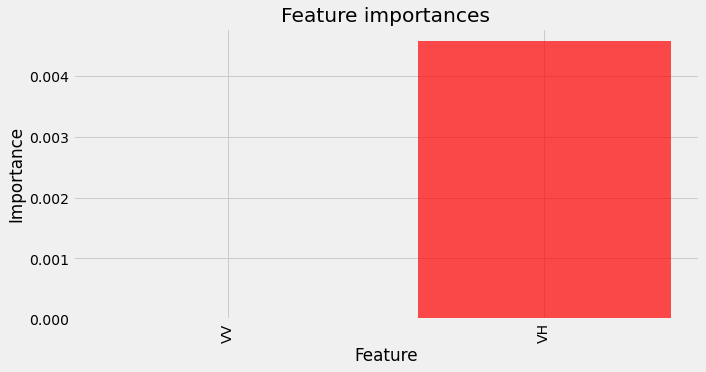

In [35]:
##### FEATURE IMPORTANCE Ensemble
##### n: controls the number of permutations per feature
model = model_AB
y_pred = model.predict_proba(X_test_ensemble)[:,1]

def get_feature_importance_ensemble(j, n):
    #### Uso la metrica AUC
    fpr , tpr , thresholds = roc_curve(y_test, y_pred) # baseline score
    s = auc(fpr, tpr)
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(X_test.shape[0]))
        X_test_ = X_test.copy()
        X_test_[:,:,:,j] = X_test[perm,:,:,j]
        X_test_ = X_test_.reshape((len(X_test_),-1))
        y_pred_ = model.predict_proba(X_test_)[:,1]
        fpr_ , tpr_ , thresholds_ = roc_curve ( y_test, y_pred_)
        s_ij = auc(fpr_, tpr_)
        total += s_ij
    return s - total / n


n_bands = X_test.shape[-1]
f = []
for j in range(n_bands) :
    f_j = get_feature_importance_ensemble(j, 10)
    f.append(f_j)# Plot

plt.figure(figsize=(10, 5))
plt.bar(range(n_bands), f, color="r", alpha=0.7)
plt.xticks(ticks=range(n_bands), labels=[bands[b] for b in best_bands], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

In [36]:
###### Dati Validation
y_pred_AB = model_AB.predict(X_val_ensemble)
score = model_AB.score(X_val_ensemble, y_val)
report = pd.DataFrame(sklearn.metrics.classification_report(y_val>thresh,y_pred_AB>thresh,target_names=target_names, output_dict=True)).transpose()
cm = confusion_matrix(y_val, y_pred_AB, normalize = 'true')

print('Numero campioni:',len(X_val_ensemble))

print(report)
print(cm)

Numero campioni: 385
              precision    recall  f1-score     support
no leak        0.497326  0.973822  0.658407  191.000000
leak           0.545455  0.030928  0.058537  194.000000
accuracy       0.498701  0.498701  0.498701    0.498701
macro avg      0.521390  0.502375  0.358472  385.000000
weighted avg   0.521578  0.498701  0.356135  385.000000
[[0.97382199 0.02617801]
 [0.96907216 0.03092784]]


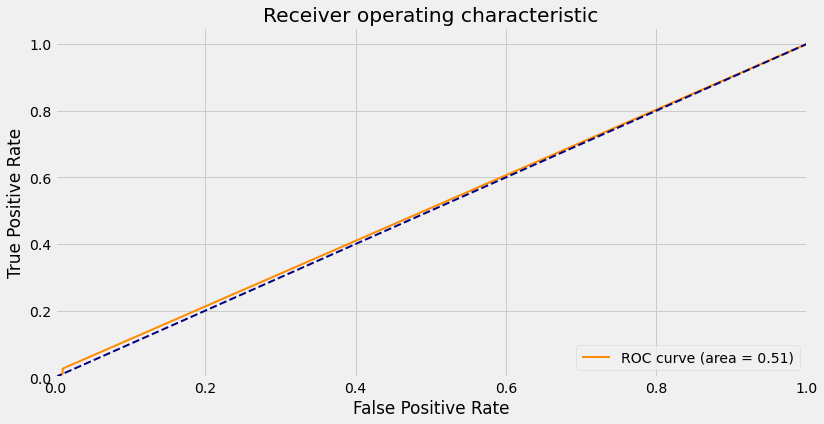

In [37]:
# Curva ROC test
y_pred_AB = model_AB.predict_proba(X_test_ensemble)[:,1]

fpr , tpr , thresholds = roc_curve ( y_test, y_pred_AB)
roc_auc = auc(fpr, tpr)
model_list.append(['model_AB',roc_auc])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

['no leak', 'leak']
[0.49699445 0.49699445 0.49699445]
[ True False  True]


count    386.000000
mean       0.500672
std        0.027245
min        0.496994
25%        0.496994
50%        0.496994
75%        0.496994
max        0.718268
dtype: float64

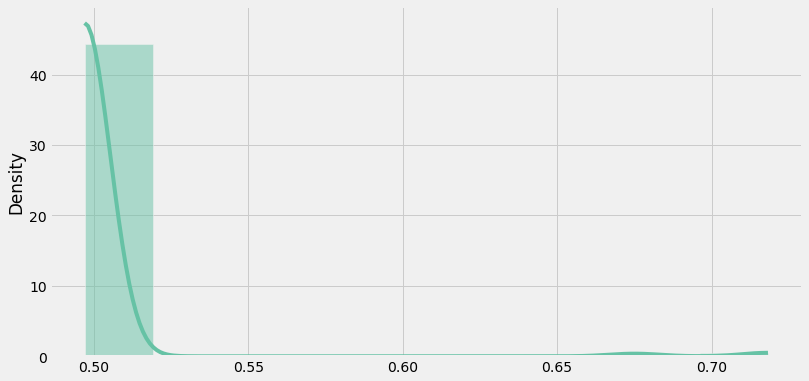

In [38]:
# Probabilità ['no leak','leak']
y_pred_AB = model_AB.predict_proba(X_test_ensemble)

print(target_names)
print(y_pred_AB[:,1][:3])
print(y_test[:3])

y_df = pd.Series(y_pred_AB[:,1])
sns.histplot(data=y_df,kde=True,stat="density")
y_df.describe()

# GradientBoost

In [39]:
n_estimators_GB = [2,4,6,8,10]
learning_rate_GB = [0.1]
max_depth_GB = [1,3]

cv_GB = 5
verbose_GB = 2

random_grid_GB = {'n_estimators': n_estimators_GB,
                 'learning_rate': learning_rate_GB,
                 'max_depth': max_depth_GB,}

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

hyperparam_GB = True

if hyperparam_GB:
    model_GB = GradientBoostingClassifier()

    randomsearch_GB = GridSearchCV( estimator = model_GB,
                       param_grid = random_grid_GB,
                       cv=cv_GB,
                       verbose= verbose_GB,
                       scoring='accuracy',
                       n_jobs=12)

    search_GB = randomsearch_GB.fit(X_train_ensemble, y_train)

    # summarize result
    print('Best Score: %s' % search_GB.best_score_)
    print('Best Hyperparameters: %s' % search_GB.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Score: 0.49248839368616526
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 4}


In [41]:
try:
    bp_GB = search_GB.best_params_
except:
    if os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD':
        bp_GB = {'n_estimators': 4, 'learning_rate': 0.1, 'max_depth': 3}
    elif os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD_FLOAT':
        bp_GB = {'n_estimators': 6, 'learning_rate': 0.1, 'max_depth': 1}
    elif os.path.split(data_path)[-1] == 'COPERNICUS_S2':
        bp_GB = {'n_estimators': 8, 'learning_rate': 0.1, 'max_depth': 1}
    elif os.path.split(data_path)[-1] == 'COPERNICUS_S2_SR':
        bp_GB = {'n_estimators': 8, 'learning_rate': 0.1, 'max_depth': 1}
        bp_GB = {'n_estimators': 6, 'learning_rate': 0.1, 'max_depth': 1}

print(bp_GB)

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 4}


In [42]:
model_GB = GradientBoostingClassifier(**bp_GB)
model_GB.fit(X_train_ensemble, y_train)

y_pred_GB = model_GB.predict(X_train_ensemble)
score = model_GB.score(X_train_ensemble, y_train)
report = pd.DataFrame(sklearn.metrics.classification_report(y_train>thresh,y_pred_GB>thresh,target_names=target_names, output_dict=True)).transpose()
cm = confusion_matrix(y_train, y_pred_GB, normalize = 'true')

print('Numero campioni:',len(X_train_ensemble))

print(report)
print(cm)

Numero campioni: 1797
              precision    recall  f1-score      support
no leak        0.580093  0.829811  0.682838   899.000000
leak           0.700587  0.398664  0.508162   898.000000
accuracy       0.614357  0.614357  0.614357     0.614357
macro avg      0.640340  0.614237  0.595500  1797.000000
weighted avg   0.640307  0.614357  0.595548  1797.000000
[[0.8298109 0.1701891]
 [0.6013363 0.3986637]]


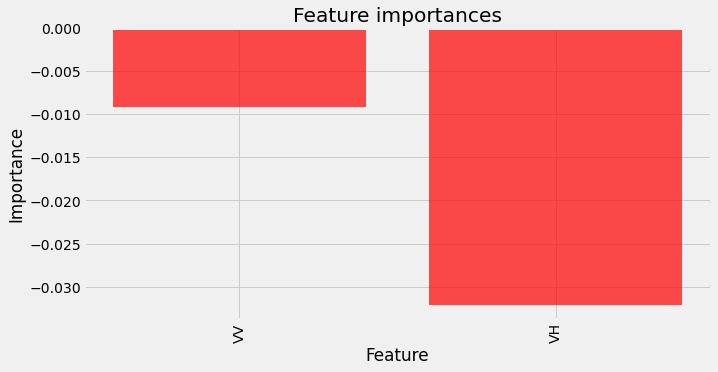

In [43]:
##### FEATURE IMPORTANCE Ensemble
##### n: controls the number of permutations per feature
model = model_GB
y_pred = model.predict_proba(X_test_ensemble)[:,1]

def get_feature_importance_ensemble(j, n):
    #### Uso la metrica AUC
    fpr , tpr , thresholds = roc_curve(y_test, y_pred) # baseline score
    s = auc(fpr, tpr)
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(X_test.shape[0]))
        X_test_ = X_test.copy()
        X_test_[:,:,:,j] = X_test[perm,:,:,j]
        X_test_ = X_test_.reshape((len(X_test_),-1))
        y_pred_ = model.predict_proba(X_test_)[:,1]
        fpr_ , tpr_ , thresholds_ = roc_curve ( y_test, y_pred_)
        s_ij = auc(fpr_, tpr_)
        total += s_ij
    return s - total / n


n_bands = X_test.shape[-1]
f = []
for j in range(n_bands) :
    f_j = get_feature_importance_ensemble(j, 10)
    f.append(f_j)# Plot

plt.figure(figsize=(10, 5))
plt.bar(range(n_bands), f, color="r", alpha=0.7)
plt.xticks(ticks=range(n_bands), labels=[bands[b] for b in best_bands], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

In [44]:
###### Dati Validation
y_pred_GB = model_GB.predict(X_val_ensemble)
score = model_GB.score(X_val_ensemble, y_val)
report = pd.DataFrame(sklearn.metrics.classification_report(y_val>thresh,y_pred_GB>thresh,target_names=target_names, output_dict=True)).transpose()
cm = confusion_matrix(y_val, y_pred_GB, normalize = 'true')

print('Numero campioni:',len(X_val_ensemble))

print(report)
print(cm)

Numero campioni: 385
              precision    recall  f1-score     support
no leak        0.494505  0.706806  0.581897  191.000000
leak           0.500000  0.288660  0.366013  194.000000
accuracy       0.496104  0.496104  0.496104    0.496104
macro avg      0.497253  0.497733  0.473955  385.000000
weighted avg   0.497274  0.496104  0.473114  385.000000
[[0.70680628 0.29319372]
 [0.71134021 0.28865979]]


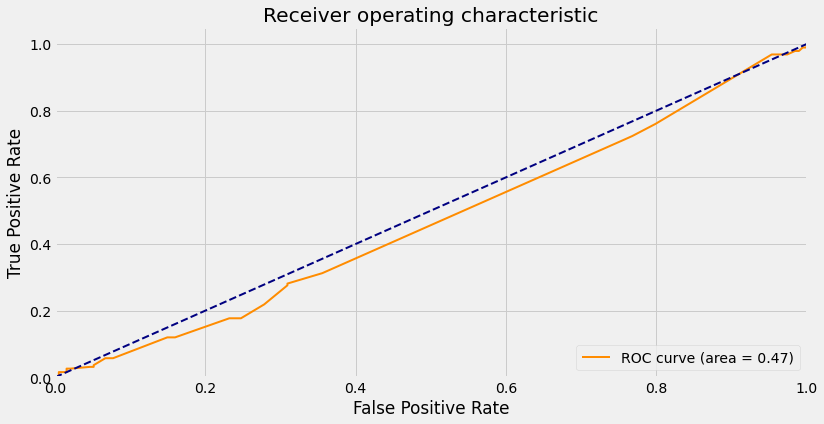

In [45]:
# Curva ROC test
y_pred_GB = model_GB.predict_proba(X_test_ensemble)[:,1]

fpr , tpr , thresholds = roc_curve ( y_test, y_pred_GB)
roc_auc = auc(fpr, tpr)
model_list.append(['model_GB',roc_auc])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

['no leak', 'leak']
[0.49959892 0.49959892 0.51667902]
[ True False  True]


count    386.000000
mean       0.498777
std        0.018333
min        0.410671
25%        0.490308
50%        0.499599
75%        0.509242
max        0.580986
dtype: float64

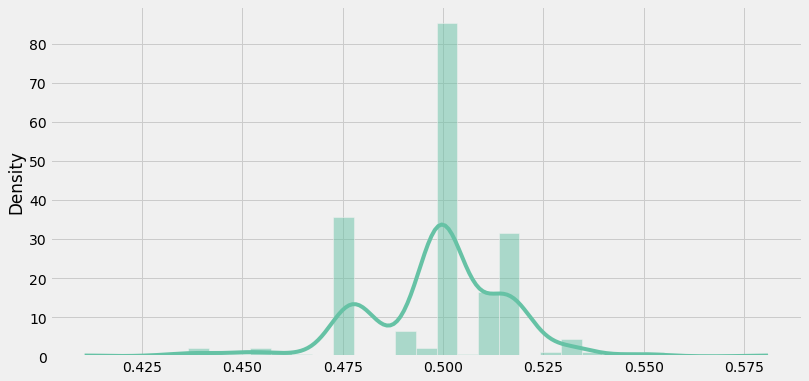

In [46]:
# Probabilità ['no leak','leak']
y_pred_GB = model_GB.predict_proba(X_test_ensemble)

print(target_names)
print(y_pred_GB[:,1][:3])
print(y_test[:3])

y_df = pd.Series(y_pred_GB[:,1])
sns.histplot(data=y_df,kde=True,stat="density")
y_df.describe()

# ExtraTreeClassifier

In [47]:
n_estimators_ET = [200,250,300,350,400]

cv_ET = 5
verbose_ET = 2

random_grid_ET = {'n_estimators': n_estimators_ET}

In [48]:
from sklearn.ensemble import ExtraTreesClassifier

hyperparam_ET = True

if hyperparam_ET:
    model_ET = ExtraTreesClassifier()

    randomsearch_ET = GridSearchCV( estimator = model_ET,
                       param_grid = random_grid_ET,
                       cv=cv_ET,
                       verbose= verbose_ET,
                       scoring='accuracy',
                       n_jobs=12)

    search_ET = randomsearch_ET.fit(X_train_ensemble, y_train)

    # summarize result
    print('Best Score: %s' % search_ET.best_score_)
    print('Best Hyperparameters: %s' % search_ET.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Score: 0.37114979882389354
Best Hyperparameters: {'n_estimators': 200}


In [49]:
try:
    bp_ET = search_ET.best_params_
except:
    if os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD':
        bp_ET = {'n_estimators': 200} 
    elif os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD_FLOAT':
        bp_ET = {'n_estimators': 300}
    elif os.path.split(data_path)[-1] == 'COPERNICUS_S2':
        bp_ET = {'n_estimators': 350}
    elif os.path.split(data_path)[-1] == 'COPERNICUS_S2_SR':
        bp_ET = {'n_estimators': 350}
        bp_ET = {'n_estimators': 300}

print(bp_ET)

{'n_estimators': 200}


In [50]:
model_ET = ExtraTreesClassifier(**bp_ET)
model_ET.fit(X_train_ensemble, y_train)

y_pred_ET = model_ET.predict(X_train_ensemble)
score = model_ET.score(X_train_ensemble, y_train)
report = pd.DataFrame(sklearn.metrics.classification_report(y_train>thresh,y_pred_ET>thresh,target_names=target_names, output_dict=True)).transpose()
cm = confusion_matrix(y_train, y_pred_ET, normalize = 'true')

print('Numero campioni:',len(X_train_ensemble))

print(report)
print(cm)

Numero campioni: 1797
              precision  recall  f1-score  support
no leak             1.0     1.0       1.0    899.0
leak                1.0     1.0       1.0    898.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0   1797.0
weighted avg        1.0     1.0       1.0   1797.0
[[1. 0.]
 [0. 1.]]


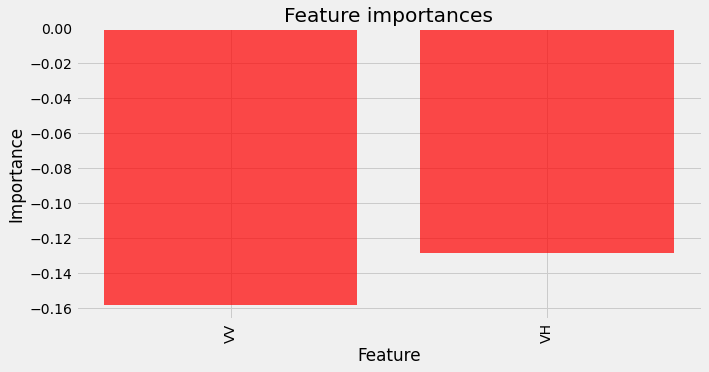

In [51]:
##### FEATURE IMPORTANCE Ensemble
##### n: controls the number of permutations per feature
model = model_ET
y_pred = model.predict_proba(X_test_ensemble)[:,1]

def get_feature_importance_ensemble(j, n):
    #### Uso la metrica AUC
    fpr , tpr , thresholds = roc_curve(y_test, y_pred) # baseline score
    s = auc(fpr, tpr)
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(X_test.shape[0]))
        X_test_ = X_test.copy()
        X_test_[:,:,:,j] = X_test[perm,:,:,j]
        X_test_ = X_test_.reshape((len(X_test_),-1))
        y_pred_ = model.predict_proba(X_test_)[:,1]
        fpr_ , tpr_ , thresholds_ = roc_curve ( y_test, y_pred_)
        s_ij = auc(fpr_, tpr_)
        total += s_ij
    return s - total / n

n_bands = X_test.shape[-1]
f = []
for j in range(n_bands) :
    f_j = get_feature_importance_ensemble(j, 10)
    f.append(f_j)# Plot

plt.figure(figsize=(10, 5))
plt.bar(range(n_bands), f, color="r", alpha=0.7)
plt.xticks(ticks=range(n_bands), labels=[bands[b] for b in best_bands], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

In [52]:
###### Dati Validation
y_pred_ET = model_ET.predict(X_val_ensemble)
score = model_ET.score(X_val_ensemble, y_val)
report = pd.DataFrame(sklearn.metrics.classification_report(y_val>thresh,y_pred_ET>thresh,target_names=target_names, output_dict=True)).transpose()
cm = confusion_matrix(y_val, y_pred_ET, normalize = 'true')

print('Numero campioni:',len(X_val_ensemble))

print(report)
print(cm)

Numero campioni: 385
              precision    recall  f1-score     support
no leak        0.372449  0.382199  0.377261  191.000000
leak           0.375661  0.365979  0.370757  194.000000
accuracy       0.374026  0.374026  0.374026    0.374026
macro avg      0.374055  0.374089  0.374009  385.000000
weighted avg   0.374068  0.374026  0.373984  385.000000
[[0.38219895 0.61780105]
 [0.63402062 0.36597938]]


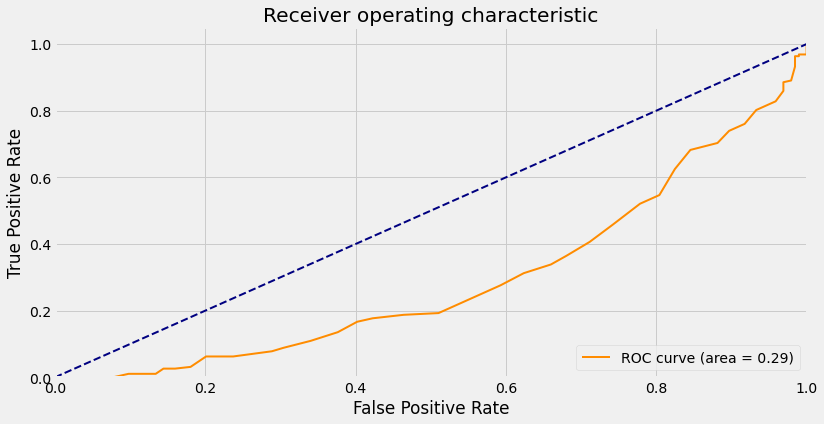

In [53]:
# Curva ROC test
y_pred_ET = model_ET.predict_proba(X_test_ensemble)[:,1]

fpr , tpr , thresholds = roc_curve ( y_test, y_pred_ET)
roc_auc = auc(fpr, tpr)
model_list.append(['model_ET',roc_auc])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

['no leak', 'leak']
[0.35  0.61  0.515]
[ True False  True]


count    386.000000
mean       0.500194
std        0.053955
min        0.340000
25%        0.465000
50%        0.497500
75%        0.540000
max        0.685000
dtype: float64

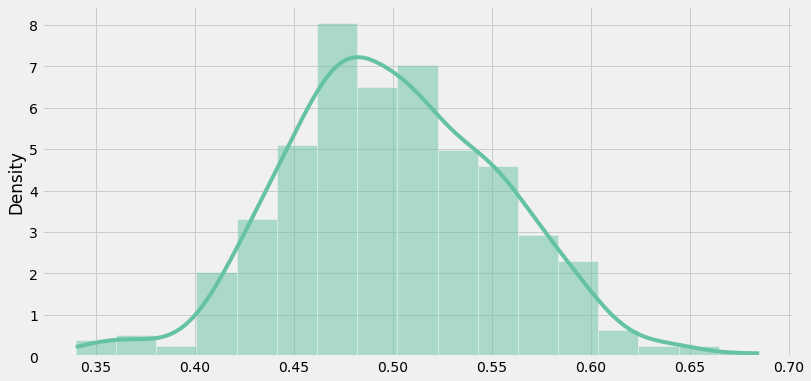

In [54]:
# Probabilità ['no leak','leak']
y_pred_ET = model_ET.predict_proba(X_test_ensemble)

print(target_names)
print(y_pred_ET[:,1][:3])
print(y_test[:3])

y_df = pd.Series(y_pred_ET[:,1])
sns.histplot(data=y_df,kde=True,stat="density")
y_df.describe()

# Modelli Neural Network

In [55]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
# from keras.layers.convolutional import AveragePooling2D, Conv2D
from tensorflow.keras.layers import BatchNormalization, MaxPool2D, AveragePooling2D, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1
# from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

X_train_CNN = X_train
X_test_CNN = X_test
X_val_CNN = X_val

input_shape = (X_train_CNN.shape[1],  X_train_CNN.shape[2], X_train_CNN.shape[3])

# Guida ai parametri
# https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844

# # Parametri Australiano
# image_data_gen_params=dict(
#         channel_shift_range=0.08, #varia i valori dei pixel random di +/- tot
#         rotation_range=10, #ruota l'immagine di +/- tot gradi
#         zoom_range=0.05, #zomma l'immagine di tot %
#         shear_range=0.05, #
#         width_shift_range=0.08, #sposta l'immagine orizzontalmente di tot % (se il parametro data è <1)
#         height_shift_range=0.08, #sposta l'immagine verticalmente di tot % (se il parametro data è <1)
#         horizontal_flip=True, #specchia l'immagine orizzontalmente
#         vertical_flip=True, #specchia l'immagine verticalmente
#         rescale=0.30, #scala i valori dell'immagine di un tot %
# )

# Parametri Carmine Default
image_data_gen_params=dict(
    #featurewise_center = False,
    rotation_range=20, #ruota l'immagine di +/- tot gradi
    zoom_range=0.15, #zomma l'immagine di +/- tot %
    shear_range=0.15, #riproietta l'immagine come vista da un'altra angolazione di +/- tot gradi
    width_shift_range=0.2, #sposta l'immagine orizzontalmente di tot % (se il parametro data è <1)
    height_shift_range=0.2, #sposta l'immagine verticalmente di tot % (se il parametro data è <1)
    horizontal_flip=True, #specchia l'immagine orizzontalmente
    vertical_flip=True, #specchia l'immagine verticalmente
    fill_mode="nearest",
)

aug = ImageDataGenerator(image_data_gen_params)

# aug.fit(X_train_CNN)

X_train_aug = aug.flow(X_train_CNN, y_train)

C:\Users\tranfa.carmine\Anaconda3\envs\satellite\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1797, 25, 25, 2) (2 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


## VGG
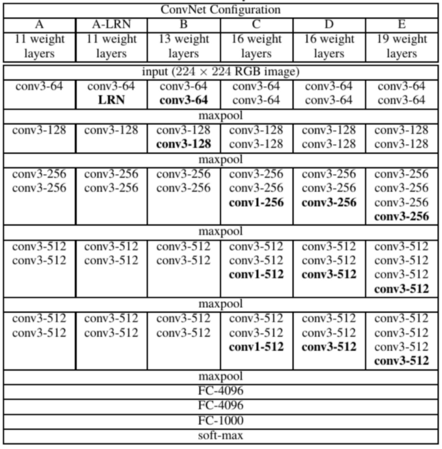

In [56]:
# Vettore Mesi
from sklearn.preprocessing import OneHotEncoder

meta_all = np.append(metadata_train, metadata_test, axis=0)
meta_all = np.append(meta_all, metadata_val, axis=0)

####### Filtro le perdite avvenute d'estate
L_dati = []
col_dati = ['mese','diametro','materiale']

# mat_dict = {'PLASTICA':['PEAD',
#                         'PVC',
#                        ],
#             'LEGA':['FERRO',
#                     'ACCIAIO',
#                     'PIOMBO',
#                     'GHISA',
#                     'OTTONE/BRONZO',
#                     'ACCIAIO ZINCATO',
#                     'ACCIAIO INOX',
#                     'FUCHS',
#                         ],
#             'COMPOSITO': ['FIBROCEMENTO',
#                           'VETRORESINA',
#                           'CEMENTO ARMATO',
#                      ],
#             'ND': ['ND']
#            }

met = meta_all
for i in range(len(met)):
    t_sat = arrow.get(met[i]['image']['properties']['system:time_start']/1000)
    dn_wo = met[i]['leak']['features'][0]['properties']['metadata']['diametro']
    mat_wo = met[i]['leak']['features'][0]['properties']['metadata']['materiale']
    m = t_sat.month
    L_dati.append([m,dn_wo,mat_wo])

df_dati = pd.DataFrame(L_dati,columns=col_dati)

df_dati['diametro'] = df_dati['diametro'].fillna(0) #fix diametro
df_dati['materiale'] = df_dati['materiale'].fillna('ND') #fix materiale

df_dati_sub = df_dati[['mese']]

feature_categoriche = ['materiale','mese']
encoder_list = []
for f in feature_categoriche:
    try:
        encoder = OneHotEncoder(categories = "auto", handle_unknown = "ignore",sparse=False)
        X_encoded = pd.DataFrame(encoder.fit_transform(df_dati_sub[[f]]))
        encoder_list.append(encoder)
        df_dati_sub = pd.concat([df_dati_sub, X_encoded],axis=1) #categorizzo la variabile
        df_dati_sub = df_dati_sub.drop(columns=f,axis=1)
    except:
        pass

X_dati = np.array(df_dati_sub, dtype = 'float')

X_dati_train = X_dati[:len(X_train)]
X_dati_test =  X_dati[len(X_train):len(X_train)+len(X_test)]
X_dati_val = X_dati[len(X_train)+len(X_test):]

print(X_dati_train.shape, X_train.shape)
print(X_dati_test.shape, X_test.shape)
print(X_dati_val.shape, X_val.shape)
X_dati_train

(1797, 12) (1797, 25, 25, 2)
(386, 12) (386, 25, 25, 2)
(385, 12) (385, 25, 25, 2)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [57]:
##### VGG

model_name = 'vgg'

X_train_aug_mesi = aug.flow([X_train_CNN, X_dati_train], y_train)
# aug.fit(X_train_CNN)

try:
    data_shape = X_dati_train.shape[1]
except:
    data_shape = 1

def conv_block(channels, kernel_size=(3,3), activation='relu',use_bn=True):
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(channels, kernel_size=kernel_size, activation=None, padding='same'))
    if use_bn:
        model.add(tf.keras.layers.BatchNormalization())

    if activation=='relu':
        model.add(tf.keras.layers.ReLU())
    return model

def vgg(input_shape, data_shape):
    input_image = tf.keras.layers.Input(shape=input_shape, name = 'images' )
    input_data = tf.keras.layers.Input(shape=data_shape, name = 'data' )
    model = conv_block(64, (3,3), 'relu', use_bn=True)(input_image)
    model = conv_block(64, (3,3), 'relu', use_bn=True)(model)
    model = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2 )(model)

    model = conv_block(128, (3,3), 'relu', use_bn=True)(model)
    model = conv_block(128, (3,3), 'relu', use_bn=True)(model)
    model = tf.keras.layers.MaxPool2D()(model)

    model = conv_block(256, (3,3), 'relu', use_bn=True)(model)
    model = conv_block(256, (3,3), 'relu', use_bn=True)(model)
    model = conv_block(256, (3,3), 'relu', use_bn=True)(model)
    model = tf.keras.layers.MaxPool2D()(model)

#     model = conv_block(512, (3,3), 'relu', use_bn=True)(model)
#     model = conv_block(512, (3,3), 'relu', use_bn=True)(model)
#     model = conv_block(512, (3,3), 'relu', use_bn=True)(model)
#     model = tf.keras.layers.MaxPool2D()(model)

    model = tf.keras.layers.Flatten()(model)
    model = tf.keras.layers.Concatenate()( [model, input_data] ) #concateno i dati
    model = tf.keras.layers.Dense(4096, activation='relu')(model)
    model = tf.keras.layers.Dense(4096, activation='relu')(model)
    model = tf.keras.layers.Dense(1, activation='sigmoid')(model)
    model = tf.keras.Model([input_image,input_data], model)
    
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#     optimizer = SGD(learning_rate = 0.01, momentum = 0.9 )
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return model

weights_file = outdir.joinpath(model_name+'_weights.h5')
model_file = outdir.joinpath(model_name+'_model.h5')

model = vgg(input_shape, data_shape) #cambiare la funzione modello
model.summary()

try:
    model.load_weights(weights_file)
    print("Modello già calcolato e disponibile")
except:
    history = model.fit(
        #X_train_CNN, y_train, 
        X_train_aug_mesi,
        validation_data=([X_val_CNN, X_dati_val], y_val),
        epochs=30,
        #batch_size=24,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=6, monitor='loss', verbose=1),
            keras.callbacks.EarlyStopping(patience=6, monitor='val_loss', verbose=1),
            keras.callbacks.ModelCheckpoint(weights_file, save_best_only=True),
        ]
    )

    pd.DataFrame(history.history).plot()

    #Recall saved weight 
    model.load_weights(weights_file)
    model.save(model_file)

score = model.evaluate([X_val_CNN, X_dati_val], y_val, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

C:\Users\tranfa.carmine\Anaconda3\envs\satellite\lib\site-packages\keras_preprocessing\image\numpy_array_iterator.py:129: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1797, 25, 25, 2) (2 channels).
  warnings.warn('NumpyArrayIterator is set to use the '


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 images (InputLayer)            [(None, 25, 25, 2)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 25, 25, 64)   1472        ['images[0][0]']                 
                                                                                                  
 sequential_1 (Sequential)      (None, 25, 25, 64)   37184       ['sequential[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 12, 12, 64)   0           ['sequential_1[0][0]']           
                                                                                              

13/13 [==============================] - 0s 25ms/step


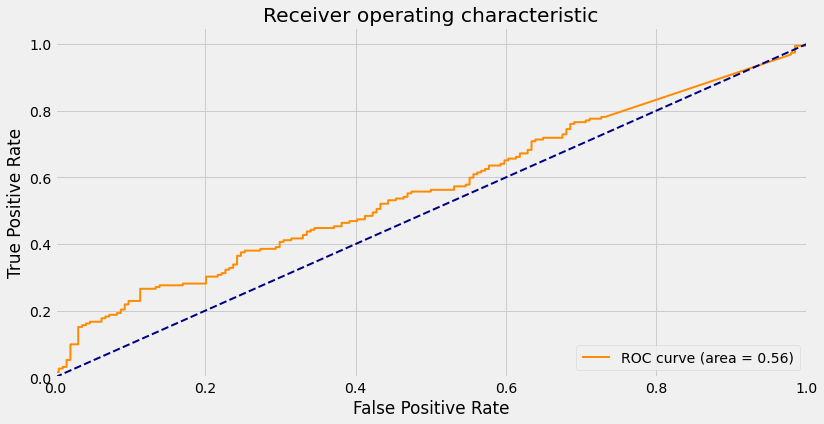

In [58]:
y_pred = model.predict( [X_test_CNN, X_dati_test], verbose=1)

fpr , tpr , thresholds = roc_curve ( y_test, y_pred)
roc_auc = auc(fpr, tpr)
if len([model_list.index(i) for i in model_list if 'model_'+model_name in i ]) > 0 :
    model_list.pop([model_list.index(i) for i in model_list if 'model_'+model_name in i ][0])
model_list.append(['model_'+model_name,roc_auc])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

13/13 [==============================] - 0s 25ms/step


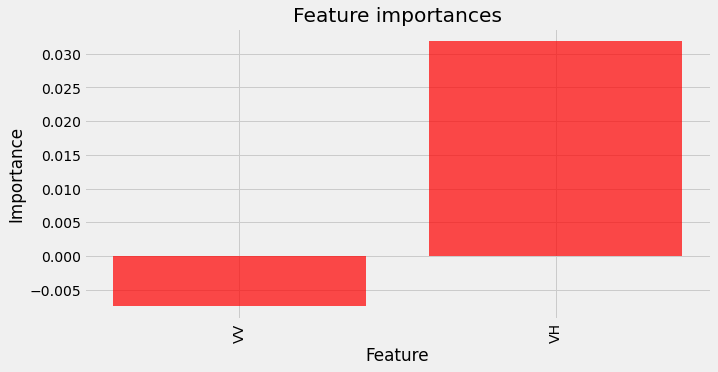

In [59]:
##### FEATURE IMPORTANCE Neural Network
##### n: controls the number of permutations per feature
y_pred = model.predict( [X_test_CNN, X_dati_test], verbose=1)

def get_feature_importance(j, n):
    #### Uso la metrica AUC
    fpr , tpr , thresholds = roc_curve ( y_test, y_pred) # baseline score
    s = auc(fpr, tpr)
    #### Uso la metrica Accuracy
#     results = model.evaluate([X_test_CNN, X_dati_test], y_test)
#     s = results[1] # baseline score
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(X_test_CNN.shape[0]))
        X_test_ = X_test_CNN.copy()
        X_test_[:,:,:,j] = X_test[perm,:,:,j]
        #### Uso la metrica AUC
        y_pred_ = model.predict([X_test_, X_dati_test])
        fpr_ , tpr_ , thresholds_ = roc_curve ( y_test, y_pred_)
        s_ij = auc(fpr_, tpr_)
        #### Uso la metrica Accuracy
#         results_ = model.evaluate([X_test_, X_dati_test], y_test)
#         s_ij = results_[1]
        total += s_ij
    return s - total / n #abs(s - total / n)


n_bands = X_test_CNN.shape[-1]
f = []
for j in range(n_bands) :
    f_j = get_feature_importance(j, 10)
    f.append(f_j)# Plot

plt.figure(figsize=(10, 5))
plt.bar(range(n_bands), f, color="r", alpha=0.7)
plt.xticks(ticks=range(n_bands), labels=[bands[b] for b in best_bands], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

In [60]:
##### VGG 16

model_name = 'vgg16'

def conv_block(channels, kernel_size=(3,3), activation='relu',use_bn=True):
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(channels, kernel_size=kernel_size, activation=None, padding='same'))
    if use_bn:
        model.add(tf.keras.layers.BatchNormalization())
    if activation=='relu':
        model.add(tf.keras.layers.ReLU())
    return model

def vgg16(input_shape):
    input_image = tf.keras.layers.Input(shape=input_shape)
    model = conv_block(64, (3,3), 'relu', use_bn=True)(input_image)
    model = conv_block(64, (3,3), 'relu', use_bn=True)(model)
    model = tf.keras.layers.MaxPool2D()(model)

    model = conv_block(128, (3,3), 'relu', use_bn=True)(model)
    model = conv_block(128, (3,3), 'relu', use_bn=True)(model)
    model = tf.keras.layers.MaxPool2D()(model)

    model = conv_block(256, (3,3), 'relu', use_bn=True)(model)
    model = conv_block(256, (3,3), 'relu', use_bn=True)(model)
    model = conv_block(256, (3,3), 'relu', use_bn=True)(model)
    model = tf.keras.layers.MaxPool2D()(model)

    model = conv_block(512, (3,3), 'relu', use_bn=True)(model)
    model = conv_block(512, (3,3), 'relu', use_bn=True)(model)
    model = conv_block(512, (3,3), 'relu', use_bn=True)(model)
    model = tf.keras.layers.MaxPool2D()(model)

    #model = conv_block(512, (3,3), 'relu', use_bn=True)(model)
    #model = conv_block(512, (3,3), 'relu', use_bn=True)(model)
    #model = conv_block(512, (3,3), 'relu', use_bn=True)(model)
    #model = tf.keras.layers.MaxPool2D()(model)

    model = tf.keras.layers.Flatten()(model)
    model = tf.keras.layers.Dense(4096, activation='relu')(model)
    model = tf.keras.layers.Dense(4096, activation='relu')(model)
    model = tf.keras.layers.Dense(1, activation='sigmoid')(model)
    model = tf.keras.Model(input_image, model)
    
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#     optimizer = SGD(learning_rate = 0.01, momentum = 0.9 )
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return model

weights_file = outdir.joinpath(model_name+'_weights.h5')
model_file = outdir.joinpath(model_name+'_model.h5')

model = vgg16(input_shape) #cambiare la funzione modello
model.summary()

try:
    model.load_weights(weights_file)
    print("Modello già calcolato e disponibile")
except:
    history = model.fit(
        #X_train_CNN, y_train, 
        X_train_aug,
        validation_data=(X_val_CNN, y_val),
        epochs=30,
        #batch_size=24,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=6, monitor='loss', verbose=1),
            keras.callbacks.EarlyStopping(patience=6, monitor='val_loss', verbose=1),
            keras.callbacks.ModelCheckpoint(weights_file, save_best_only=True),
        ]
    )

    pd.DataFrame(history.history).plot()

    #Recall saved weight 
    model.load_weights(weights_file)
    model.save(model_file)

score = model.evaluate(X_val_CNN, y_val, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 2)]       0         
                                                                 
 sequential_7 (Sequential)   (None, 25, 25, 64)        1472      
                                                                 
 sequential_8 (Sequential)   (None, 25, 25, 64)        37184     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 sequential_9 (Sequential)   (None, 12, 12, 128)       74368     
                                                                 
 sequential_10 (Sequential)  (None, 12, 12, 128)       148096    
                                                           

13/13 [==============================] - 1s 35ms/step


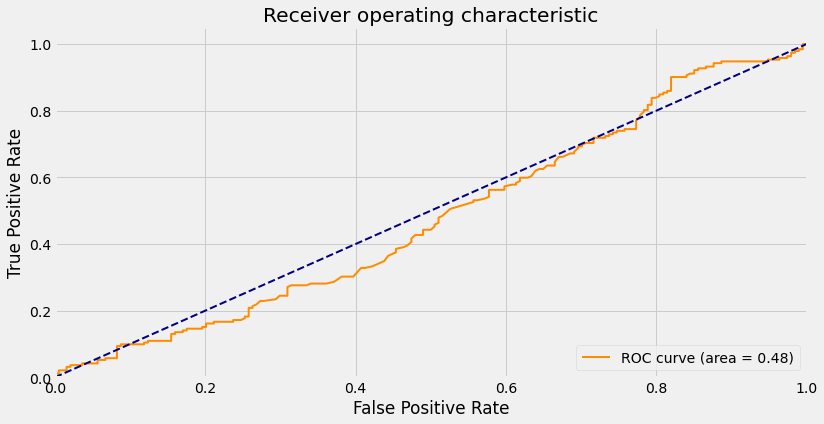

In [61]:
y_pred = model.predict(X_test_CNN, verbose=1)

fpr , tpr , thresholds = roc_curve ( y_test, y_pred)
roc_auc = auc(fpr, tpr)
if len([model_list.index(i) for i in model_list if 'model_'+model_name in i ]) > 0 :
    model_list.pop([model_list.index(i) for i in model_list if 'model_'+model_name in i ][0])
model_list.append(['model_'+model_name,roc_auc])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

13/13 [==============================] - 0s 35ms/step


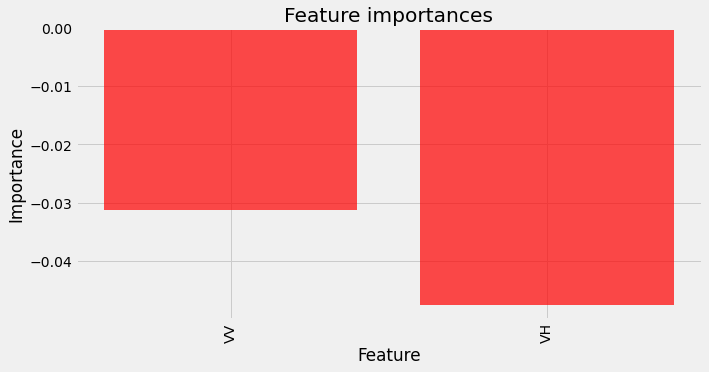

In [62]:
##### FEATURE IMPORTANCE Neural Network
##### n: controls the number of permutations per feature
y_pred = model.predict( X_test_CNN, verbose=1)

def get_feature_importance(j, n):
    #### Uso la metrica AUC
    fpr , tpr , thresholds = roc_curve ( y_test, y_pred) # baseline score
    s = auc(fpr, tpr)
    #### Uso la metrica Accuracy
#     results = model.evaluate(X_test_CNN, y_test)
#     s = results[1] # baseline score
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(X_test_CNN.shape[0]))
        X_test_ = X_test_CNN.copy()
        X_test_[:,:,:,j] = X_test[perm,:,:,j]
        #### Uso la metrica AUC
        y_pred_ = model.predict(X_test_)
        fpr_ , tpr_ , thresholds_ = roc_curve ( y_test, y_pred_)
        s_ij = auc(fpr_, tpr_)
        #### Uso la metrica Accuracy
#         results_ = model.evaluate(X_test_, y_test)
#         s_ij = results_[1]
        total += s_ij
    return s - total / n #abs(s - total / n)


n_bands = X_test_CNN.shape[-1]
f = []
for j in range(n_bands) :
    f_j = get_feature_importance(j, 10)
    f.append(f_j)# Plot

plt.figure(figsize=(10, 5))
plt.bar(range(n_bands), f, color="r", alpha=0.7)
plt.xticks(ticks=range(n_bands), labels=[bands[b] for b in best_bands], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

# Statoil/C-CORE Iceberg Classifier Challenge
##### https://www.kaggle.com/sh0wmaker/binary-image-classification-keras-for-lecture

In [63]:
model_name = 'statoil'

def statoil(input_shape):
    #Buildin the model
    model = Sequential()
    #Conv Layer1
    model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
    model.add(Dropout(0.2))
    
    #Conv Layer2
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))
    
    #Conv Layer3
    model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.2))
    
#     #Conv Layer4
#     model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#     model.add(Dropout(0.2))
    
    #Flatten the data for upcoming dense layers
    model.add(Flatten())
    
    #Dense Layers
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    #Sigmoid Layer
    #Adam makes model Optimization
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#     optimizer = SGD(learning_rate = 0.01, momentum = 0.9 )
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

weights_file = outdir.joinpath(model_name+'_weights.h5')
model_file = outdir.joinpath(model_name+'_model.h5')

model = statoil(input_shape)
model.summary()

try:
    model.load_weights(weights_file)
    print("Modello già calcolato e disponibile")
except:
    history = model.fit(
        #X_train_CNN, y_train, 
        X_train_aug,
        validation_data=(X_val_CNN, y_val),
        epochs=120,
        batch_size=24,
        callbacks=[
            #keras.callbacks.EarlyStopping('val_loss', patience=2, mode='min'),
            keras.callbacks.ModelCheckpoint(weights_file, save_best_only=True),
        ]
    )

    pd.DataFrame(history.history).plot()

    #Recall saved weight 
    model.load_weights(weights_file)
    model.save(model_file)

score = model.evaluate(X_val_CNN, y_val, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 23, 23, 64)        1216      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 11, 11, 64)        0         
                                                                 
 conv2d_18 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 128)       

13/13 [==============================] - 0s 3ms/step


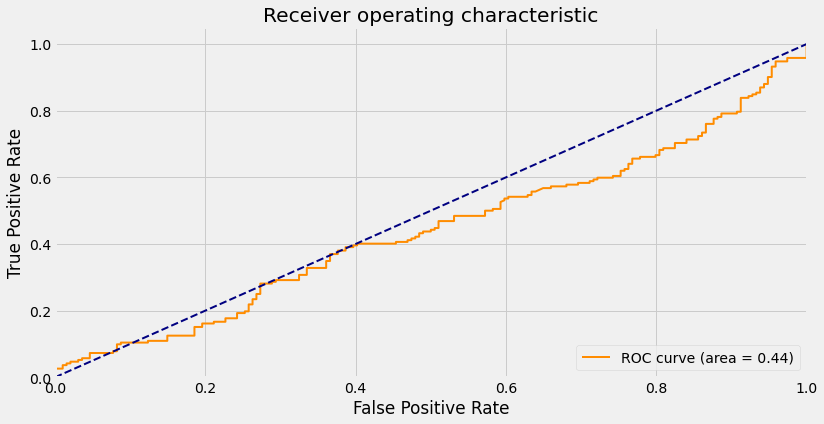

In [64]:
y_pred = model.predict(X_test_CNN, verbose=1)

fpr , tpr , thresholds = roc_curve ( y_test, y_pred)
roc_auc = auc(fpr, tpr)
if len([model_list.index(i) for i in model_list if model_name in i ]) > 0 :
    model_list.pop([model_list.index(i) for i in model_list if model_name in i ][0])
model_list.append(['model_'+model_name,roc_auc])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

13/13 [==============================] - 0s 3ms/step


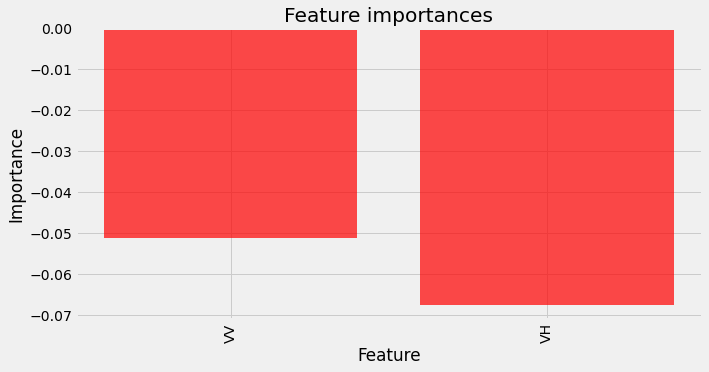

In [65]:
##### FEATURE IMPORTANCE Neural Network
##### n: controls the number of permutations per feature
y_pred = model.predict( X_test_CNN, verbose=1)

def get_feature_importance(j, n):
    #### Uso la metrica AUC
    fpr , tpr , thresholds = roc_curve ( y_test, y_pred) # baseline score
    s = auc(fpr, tpr)
    #### Uso la metrica Accuracy
#     results = model.evaluate(X_test_CNN, y_test)
#     s = results[1] # baseline score
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(X_test_CNN.shape[0]))
        X_test_ = X_test_CNN.copy()
        X_test_[:,:,:,j] = X_test[perm,:,:,j]
        #### Uso la metrica AUC
        y_pred_ = model.predict(X_test_)
        fpr_ , tpr_ , thresholds_ = roc_curve ( y_test, y_pred_)
        s_ij = auc(fpr_, tpr_)
        #### Uso la metrica Accuracy
#         results_ = model.evaluate(X_test_, y_test)
#         s_ij = results_[1]
        total += s_ij
    return s - total / n #abs(s - total / n)


n_bands = X_test_CNN.shape[-1]
f = []
for j in range(n_bands) :
    f_j = get_feature_importance(j, 10)
    f.append(f_j)# Plot

plt.figure(figsize=(10, 5))
plt.bar(range(n_bands), f, color="r", alpha=0.7)
plt.xticks(ticks=range(n_bands), labels=[bands[b] for b in best_bands], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

## ResNet
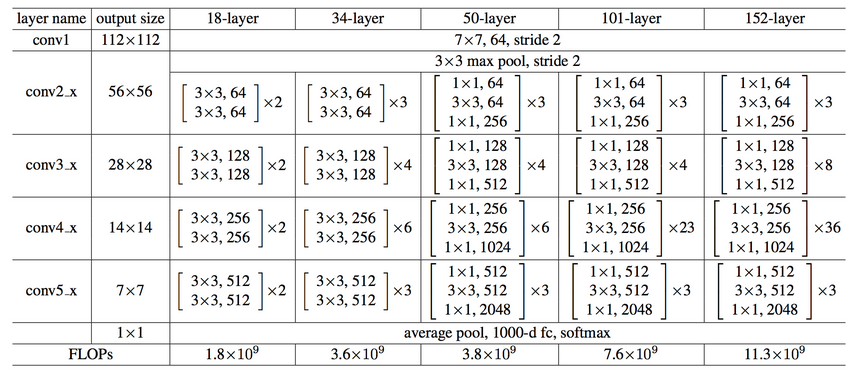

In [66]:
##### ResNet 18

model_name = 'resnet18'

def conv_block(channels, kernel_size=(3,3), strides=(1,1), activation='relu',use_bn=True):
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(channels, kernel_size=kernel_size, strides=strides, activation=None, padding='same'))
    if use_bn:
        model.add(tf.keras.layers.BatchNormalization())
    if activation=='relu':
        model.add(tf.keras.layers.ReLU())
    return model

def residual(x, c_1, c_2, ks_1, ks_2, st=1):
    if not x.shape[-1]==c_2 or st==2:  # Linear projection when different
        skip_con=conv_block(channels=c_2, kernel_size=(1,1), strides=(st, st), activation=None)(x)  # w/o relu activation
    else:
        skip_con=x
  
    x=conv_block(c_1, (ks_1, ks_1), strides=(st, st))(x)
    x=conv_block(c_2, (ks_2, ks_2))(x)
    return tf.keras.layers.Add()([x, skip_con])

def resnet18(input_shape):
    input_image = tf.keras.layers.Input(shape=input_shape)
    x = conv_block(64, (7,7), (2,2))(input_image)
    x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)

    x = residual(x, 64, 64, 3,3)
    x = residual(x, 64, 64, 3,3)

    x = residual(x, 128, 128, 3,3)
    x = residual(x, 128, 128, 3,3)

    x = residual(x, 256, 256, 3,3)
    x = residual(x, 256, 256, 3,3)

    x = residual(x, 512, 512, 3,3)
    x = residual(x, 512, 512, 3,3)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1000, activation='relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(input_image, x)
    
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#     optimizer = SGD(learning_rate = 0.01, momentum = 0.9 )
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return model

weights_file = outdir.joinpath(model_name+'_weights.h5')
model_file = outdir.joinpath(model_name+'_model.h5')

model = resnet18(input_shape) #cambiare la funzione modello
model.summary()

try:
    model.load_weights(weights_file)
    print("Modello già calcolato e disponibile")
except:
    history = model.fit(
        #X_train_CNN, y_train, 
        X_train_aug,
        validation_data=(X_val_CNN, y_val),
        epochs=30,
        batch_size=256,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=6, monitor='loss', verbose=1),
            keras.callbacks.EarlyStopping(patience=6, monitor='val_loss', verbose=1),
            keras.callbacks.ModelCheckpoint(weights_file, save_best_only=True),
        ]
    )

    pd.DataFrame(history.history).plot()

    #Recall saved weight 
    model.load_weights(weights_file)
    model.save(model_file)

score = model.evaluate(X_val_CNN, y_val, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 25, 25, 2)]  0           []                               
                                                                                                  
 sequential_18 (Sequential)     (None, 13, 13, 64)   6592        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_10 (MaxPooling2D  (None, 7, 7, 64)    0           ['sequential_18[0][0]']          
 )                                                                                                
                                                                                                  
 sequential_19 (Sequential)     (None, 7, 7, 64)     37184       ['max_pooling2d_10[0][0]'] 

13/13 [==============================] - 2s 84ms/step - loss: 0.6910 - accuracy: 0.5403
Test loss: 0.6909512877464294
Test accuracy: 0.5402597188949585


13/13 [==============================] - 1s 91ms/step


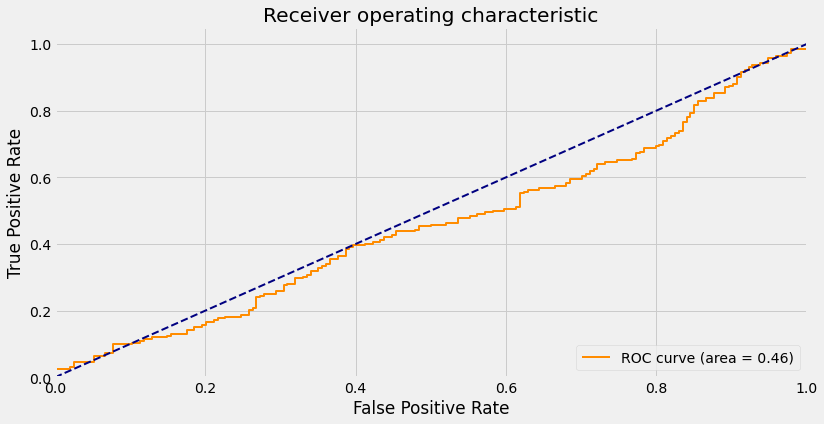

In [67]:
y_pred = model.predict(X_test_CNN, verbose=1)

fpr , tpr , thresholds = roc_curve ( y_test, y_pred)
roc_auc = auc(fpr, tpr)
if len([model_list.index(i) for i in model_list if 'model_'+model_name in i ]) > 0 :
    model_list.pop([model_list.index(i) for i in model_list if 'model_'+model_name in i ][0])
model_list.append(['model_'+model_name,roc_auc])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

13/13 [==============================] - 1s 87ms/step


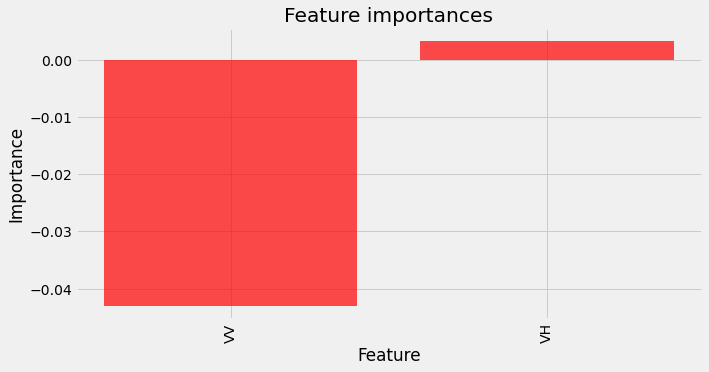

In [68]:
##### FEATURE IMPORTANCE Neural Network
##### n: controls the number of permutations per feature
y_pred = model.predict( X_test_CNN, verbose=1)

def get_feature_importance(j, n):
    #### Uso la metrica AUC
    fpr , tpr , thresholds = roc_curve ( y_test, y_pred) # baseline score
    s = auc(fpr, tpr)
    #### Uso la metrica Accuracy
#     results = model.evaluate(X_test_CNN, y_test)
#     s = results[1] # baseline score
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(X_test_CNN.shape[0]))
        X_test_ = X_test_CNN.copy()
        X_test_[:,:,:,j] = X_test[perm,:,:,j]
        #### Uso la metrica AUC
        y_pred_ = model.predict(X_test_)
        fpr_ , tpr_ , thresholds_ = roc_curve ( y_test, y_pred_)
        s_ij = auc(fpr_, tpr_)
        #### Uso la metrica Accuracy
#         results_ = model.evaluate(X_test_, y_test)
#         s_ij = results_[1]
        total += s_ij
    return s - total / n #abs(s - total / n)


n_bands = X_test_CNN.shape[-1]
f = []
for j in range(n_bands) :
    f_j = get_feature_importance(j, 10)
    f.append(f_j)# Plot

plt.figure(figsize=(10, 5))
plt.bar(range(n_bands), f, color="r", alpha=0.7)
plt.xticks(ticks=range(n_bands), labels=[bands[b] for b in best_bands], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

In [69]:
# ##### ResNet 34

# model_name = 'resnet34'

# def conv_block(channels, kernel_size=(3,3), strides=(1,1), activation='relu',use_bn=True):
#     model=tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Conv2D(channels, kernel_size=kernel_size, strides=strides, activation=None, padding='same'))
#     if use_bn:
#         model.add(tf.keras.layers.BatchNormalization())
    
#     if activation=='relu':
#         model.add(tf.keras.layers.ReLU())
#     return model

# def residual(x, c_1, c_2, ks_1, ks_2, st=1):
#     if not x.shape[-1]==c_2 or st==2:  # Linear projection when different
#         skip_con=conv_block(channels=c_2, kernel_size=(1,1), strides=(st, st), activation=None)(x)  # w/o relu activation
#     else:
#         skip_con=x

#     x=conv_block(c_1, (ks_1, ks_1), strides=(st, st))(x)
#     x=conv_block(c_2, (ks_2, ks_2))(x)
#     return tf.keras.layers.Add()([x, skip_con])

# def resnet34(input_shape):
#     input_image = tf.keras.layers.Input(shape=input_shape)
#     x = conv_block(64, (7,7), (2,2))(input_image)
#     x = MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)

#     x = residual(x, 64, 64, 3,3)
#     x = residual(x, 64, 64, 3,3)
#     x = residual(x, 64, 64, 3,3)

#     x = residual(x, 128, 128, 3,3)
#     x = residual(x, 128, 128, 3,3)
#     x = residual(x, 128, 128, 3,3)
#     x = residual(x, 128, 128, 3,3)

#     x = residual(x, 256, 256, 3,3)
#     x = residual(x, 256, 256, 3,3)
#     x = residual(x, 256, 256, 3,3)
#     x = residual(x, 256, 256, 3,3)
#     x = residual(x, 256, 256, 3,3)
#     x = residual(x, 256, 256, 3,3)

#     x = residual(x, 512, 512, 3,3)
#     x = residual(x, 512, 512, 3,3)
#     x = residual(x, 512, 512, 3,3)

#     x = tf.keras.layers.GlobalAveragePooling2D()(x)
#     x = tf.keras.layers.Dense(1000, activation='relu')(x)
#     x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
#     model = tf.keras.Model(input_image, x)
    
#     optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# #     optimizer = SGD(learning_rate = 0.01, momentum = 0.9 )
#     model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
#     return model

# weights_file = outdir.joinpath(model_name+'_weights.h5')
# model_file = outdir.joinpath(model_name+'_model.h5')

# model = resnet34(input_shape) #cambiare la funzione modello
# model.summary()

# try:
#     model.load_weights(weights_file)
#     print("Modello già calcolato e disponibile")
# except:
#     history = model.fit(
#         #X_train_CNN, y_train, 
#         X_train_aug,
#         validation_data=(X_val_CNN, y_val),
#         epochs=30,
#         #batch_size=24,
#         callbacks=[
#             keras.callbacks.EarlyStopping(patience=6, monitor='loss', verbose=1),
#             keras.callbacks.EarlyStopping(patience=6, monitor='val_loss', verbose=1),
#             keras.callbacks.ModelCheckpoint(weights_file, save_best_only=True),
#         ]
#     )

#     pd.DataFrame(history.history).plot()

#     #Recall saved weight 
#     model.load_weights(weights_file)
#     model.save(model_file)

# score = model.evaluate(X_val_CNN, y_val, verbose=1)
# print('Test loss:', score[0])
# print('Test accuracy:', score[1])

In [70]:
# y_pred = model.predict(X_test_CNN, verbose=1)

# fpr , tpr , thresholds = roc_curve ( y_test, y_pred)
# roc_auc = auc(fpr, tpr)
# if len([model_list.index(i) for i in model_list if 'model_'+model_name in i ]) > 0 :
#     model_list.pop([model_list.index(i) for i in model_list if 'model_'+model_name in i ][0])
# model_list.append(['model_'+model_name,roc_auc])
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc="lower right")
# plt.show()

In [71]:
# ##### FEATURE IMPORTANCE Neural Network
# ##### n: controls the number of permutations per feature
# y_pred = model.predict( X_test_CNN, verbose=1)

# def get_feature_importance(j, n):
#     #### Uso la metrica AUC
#     fpr , tpr , thresholds = roc_curve ( y_test, y_pred) # baseline score
#     s = auc(fpr, tpr)
#     #### Uso la metrica Accuracy
# #     results = model.evaluate(X_test_CNN, y_test)
# #     s = results[1] # baseline score
#     total = 0.0
#     for i in range(n):
#         perm = np.random.permutation(range(X_test_CNN.shape[0]))
#         X_test_ = X_test_CNN.copy()
#         X_test_[:,:,:,j] = X_test[perm,:,:,j]
#         #### Uso la metrica AUC
#         y_pred_ = model.predict(X_test_)
#         fpr_ , tpr_ , thresholds_ = roc_curve ( y_test, y_pred_)
#         s_ij = auc(fpr_, tpr_)
#         #### Uso la metrica Accuracy
# #         results_ = model.evaluate(X_test_, y_test)
# #         s_ij = results_[1]
#         total += s_ij
#     return s - total / n #abs(s - total / n)


# n_bands = X_test_CNN.shape[-1]
# f = []
# for j in range(n_bands) :
#     f_j = get_feature_importance(j, 10)
#     f.append(f_j)# Plot

# plt.figure(figsize=(10, 5))
# plt.bar(range(n_bands), f, color="r", alpha=0.7)
# plt.xticks(ticks=range(n_bands), labels=[bands[b] for b in best_bands], rotation=90)
# plt.xlabel("Feature")
# plt.ylabel("Importance")
# plt.title("Feature importances")
# plt.show()

## DenseNet

In [72]:
model_name = 'densenet'

def conv_block(channels, kernel_size=(3,3), strides=(1,1), activation='relu',use_bn=True):
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(channels, kernel_size=kernel_size, strides=strides, activation=None, padding='same'))
    if use_bn:
        model.add(tf.keras.layers.BatchNormalization())

    if activation=='relu':
        model.add(tf.keras.layers.ReLU())
    return model

def transition_block(x):
    c=x.shape[-1] # num channels
    x=tf.keras.layers.BatchNormalization()(x)
    x=tf.keras.layers.ReLU()(x)
    x=tf.keras.layers.Conv2D(c//2,(1,1))(x)
    x=tf.keras.layers.AveragePooling2D()(x)
    return x

def dense_block(x, k, rp, intermediate_channels=128):
    for _ in range(rp):
        x_branch=tf.keras.layers.BatchNormalization()(x)
        x_branch=tf.keras.layers.ReLU()(x_branch)
        x_branch=tf.keras.layers.Conv2D(intermediate_channels, (1,1), padding='same')(x_branch)

        x_branch=tf.keras.layers.BatchNormalization()(x_branch)
        x_branch=tf.keras.layers.ReLU()(x_branch)
        x_branch=tf.keras.layers.Conv2D(k, (3,3), padding='same')(x_branch)

        x=tf.keras.layers.concatenate([x, x_branch])
    return x

def densnet(input_shape, k = 32):
    input_image = tf.keras.layers.Input(shape=input_shape)
    #x = conv_block(64, (7,7), (2,2))(input_image)
    #x = tf.keras.layers.MaxPool2D((3, 3), padding='same', strides=(2, 2))(x)
    x = conv_block(64, (7,7))(input_image)
    x = tf.keras.layers.MaxPool2D((2, 2), padding='same', strides=(2, 2))(x)
    #dense block 1
    x=dense_block(x, k, 6)
    x=transition_block(x)
    # dense block 2
    x=dense_block(x, k, 12)
    x=transition_block(x)
    ## dense block 3
    #x=dense_block(x, k, 24)
    #x=transition_block(x)
    #dense block 4
    x=dense_block(x, k, 16)
    x=tf.keras.layers.GlobalAveragePooling2D()(x)

    x=tf.keras.layers.Dense(1000, 'relu')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(input_image, x)
    
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#     optimizer = SGD(learning_rate = 0.01, momentum = 0.9 )
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    return model

weights_file = outdir.joinpath(model_name+'_weights.h5')
model_file = outdir.joinpath(model_name+'_model.h5')

model = densnet(input_shape) #cambiare la funzione modello
model.summary()

try:
    model.load_weights(weights_file)
    print("Modello già calcolato e disponibile")
except:
    history = model.fit(
        #X_train_CNN, y_train, 
        X_train_aug,
        validation_data=(X_val_CNN, y_val),
        epochs=30,
        #batch_size=24,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=6, monitor='loss', verbose=1),
            keras.callbacks.EarlyStopping(patience=6, monitor='val_loss', verbose=1),
            keras.callbacks.ModelCheckpoint(weights_file, save_best_only=True),
        ]
    )

    pd.DataFrame(history.history).plot()

    #Recall saved weight 
    model.load_weights(weights_file)
    model.save(model_file)

score = model.evaluate(X_val_CNN, y_val, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25, 25, 2)]  0           []                               
                                                                                                  
 sequential_38 (Sequential)     (None, 25, 25, 64)   6592        ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_11 (MaxPooling2D  (None, 13, 13, 64)  0           ['sequential_38[0][0]']          
 )                                                                                                
                                                                                                  
 batch_normalization_38 (BatchN  (None, 13, 13, 64)  256         ['max_pooling2d_11[0][0]'] 

Modello già calcolato e disponibile
13/13 [==============================] - 3s 61ms/step - loss: 0.6941 - accuracy: 0.4987
Test loss: 0.6941230297088623
Test accuracy: 0.4987013041973114


13/13 [==============================] - 2s 62ms/step


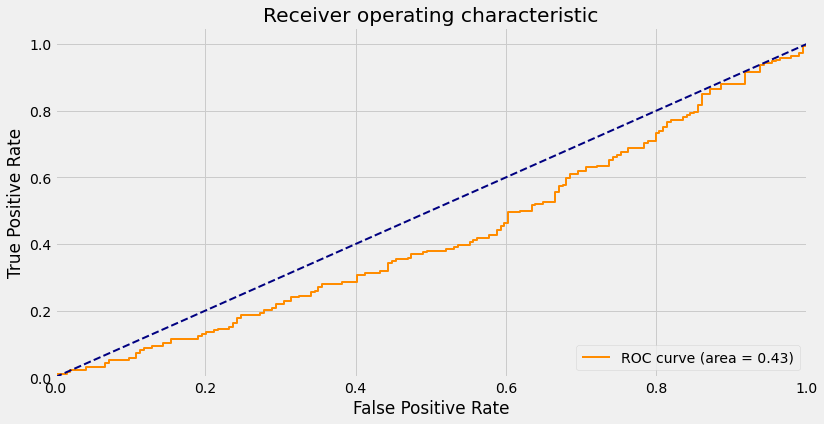

In [73]:
y_pred = model.predict(X_test_CNN, verbose=1)

fpr , tpr , thresholds = roc_curve ( y_test, y_pred)
roc_auc = auc(fpr, tpr)
if len([model_list.index(i) for i in model_list if 'model_'+model_name in i ]) > 0 :
    model_list.pop([model_list.index(i) for i in model_list if 'model_'+model_name in i ][0])
model_list.append(['model_'+model_name,roc_auc])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

13/13 [==============================] - 1s 69ms/step


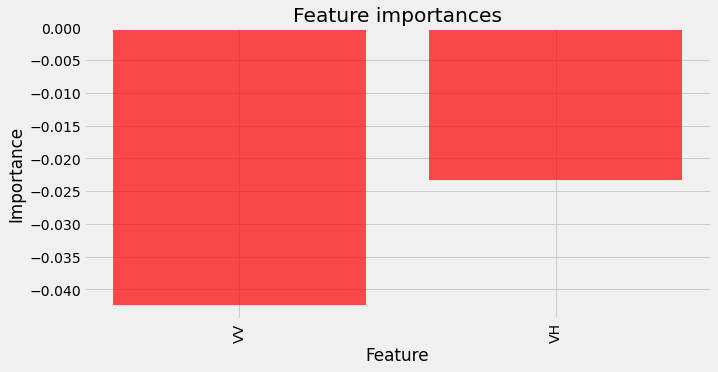

In [74]:
##### FEATURE IMPORTANCE Neural Network
##### n: controls the number of permutations per feature
y_pred = model.predict( X_test_CNN, verbose=1)

def get_feature_importance(j, n):
    #### Uso la metrica AUC
    fpr , tpr , thresholds = roc_curve ( y_test, y_pred) # baseline score
    s = auc(fpr, tpr)
    #### Uso la metrica Accuracy
#     results = model.evaluate(X_test_CNN, y_test)
#     s = results[1] # baseline score
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(X_test_CNN.shape[0]))
        X_test_ = X_test_CNN.copy()
        X_test_[:,:,:,j] = X_test[perm,:,:,j]
        #### Uso la metrica AUC
        y_pred_ = model.predict(X_test_)
        fpr_ , tpr_ , thresholds_ = roc_curve ( y_test, y_pred_)
        s_ij = auc(fpr_, tpr_)
        #### Uso la metrica Accuracy
#         results_ = model.evaluate(X_test_, y_test)
#         s_ij = results_[1]
        total += s_ij
    return s - total / n #abs(s - total / n)


n_bands = X_test_CNN.shape[-1]
f = []
for j in range(n_bands) :
    f_j = get_feature_importance(j, 10)
    f.append(f_j)# Plot

plt.figure(figsize=(10, 5))
plt.bar(range(n_bands), f, color="r", alpha=0.7)
plt.xticks(ticks=range(n_bands), labels=[bands[b] for b in best_bands], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

# U-Net

In [75]:
##### U-Net

model_name = 'u_net'

def u_net(input_size):
    inputs = Input(input_size)
    crop_input = Cropping2D(cropping=((1, 0), (1, 0)))(inputs) #taglia una riga e una colonna di zeri per diminuire la dim dell'immagine
    conv_d1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(crop_input)
    conv_d1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_d1)
    pool_d1 = MaxPooling2D(pool_size=(2, 2))(conv_d1)
    
    conv_d2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool_d1)
    conv_d2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_d2)
    pool_d2 = MaxPooling2D(pool_size=(2, 2))(conv_d2)
    
    conv_d3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool_d2)
    conv_d3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_d3)
#     pool_d3 = MaxPooling2D(pool_size=(2, 2))(conv_d3)
    
    drop_d3 = Dropout(0.5)(conv_d3)
    pool_d3 = MaxPooling2D(pool_size=(2, 2))(drop_d3)
    
#     conv_d4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool_d3)
#     conv_d4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_d4)
#     drop_d4 = Dropout(0.5)(conv_d4)
#     pool_d4 = MaxPooling2D(pool_size=(2, 2))(drop_d4)

    conv_d4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool_d3)
    conv_d4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_d4)
    drop_d4 = Dropout(0.5)(conv_d4)

#     conv_d5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool_d4)
#     conv_d5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_d5)
#     drop_d5 = Dropout(0.5)(conv_d5)

#     up_u5 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (3,3))(drop_d5))
#     merge_u4 = tf.keras.layers.concatenate([drop_d4,up_u5], axis = 3)
#     conv_u4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_u4)
#     conv_u4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_u4)

#     up_u3 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(drop_d3)
    up_u3 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_d4))
    merge_u3 = tf.keras.layers.concatenate([conv_d3,up_u3], axis = 3)
    conv_u3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_u3)
    conv_u3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_u3)

    up_u2 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_u3))
    merge_u2 = tf.keras.layers.concatenate([conv_d2,up_u2], axis = 3)
    conv_u2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_u2)
    conv_u2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_u2)

    up_u1 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_u2))
#     up_u1 = ZeroPadding2D(padding=((1, 0), (1, 0)))(up_u1) #aggiunge una riga e una colonna di zeri per aumentare la dim dell'immagine
    merge_u1 = tf.keras.layers.concatenate([conv_d1,up_u1], axis = 3)
    conv_u1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge_u1)
    conv_u1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_u1)
    conv_u1 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv_u1)
    conv_0 = Conv2D(1, 1, activation = 'sigmoid')(conv_u1)
    
    conv_0 = tf.keras.layers.GlobalAveragePooling2D()(conv_0) #aggiunta

    model = Model(inputs, conv_0)
    
    optimizer = Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

weights_file = outdir.joinpath(model_name+'_weights.h5')
model_file = outdir.joinpath(model_name+'_model.h5')

model = u_net(input_shape) #cambiare la funzione modello
model.summary()

try:
    model.load_weights(weights_file)
    print("Modello già calcolato e disponibile")
except:
    history = model.fit(
#         X_train_CNN, y_train,
        X_train_aug,
        validation_data=(X_val_CNN, y_val),
        epochs=30,
        #batch_size=24,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=6, monitor='loss', verbose=1),
            keras.callbacks.EarlyStopping(patience=6, monitor='val_loss', verbose=1),
            keras.callbacks.ModelCheckpoint(weights_file, save_best_only=True),
        ]
    )

    pd.DataFrame(history.history).plot()

    #Recall saved weight 
    model.load_weights(weights_file)
    model.save(model_file)

score = model.evaluate(X_val_CNN, y_val, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 25, 25, 2)]  0           []                               
                                                                                                  
 cropping2d (Cropping2D)        (None, 24, 24, 2)    0           ['input_4[0][0]']                
                                                                                                  
 conv2d_111 (Conv2D)            (None, 24, 24, 64)   1216        ['cropping2d[0][0]']             
                                                                                                  
 conv2d_112 (Conv2D)            (None, 24, 24, 64)   36928       ['conv2d_111[0][0]']             
                                                                                            

13/13 [==============================] - 1s 71ms/step


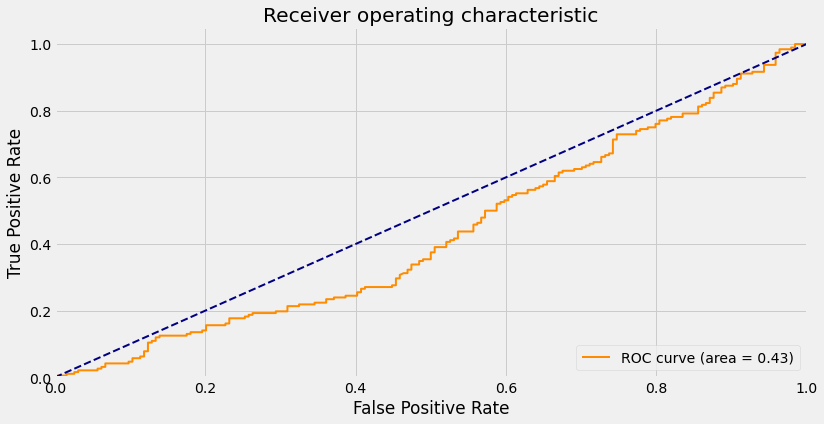

In [76]:
y_pred = model.predict(X_test_CNN, verbose=1)

fpr , tpr , thresholds = roc_curve ( y_test, y_pred)
roc_auc = auc(fpr, tpr)
if len([model_list.index(i) for i in model_list if 'model_'+model_name in i ]) > 0 :
    model_list.pop([model_list.index(i) for i in model_list if 'model_'+model_name in i ][0])
model_list.append(['model_'+model_name,roc_auc])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

13/13 [==============================] - 1s 74ms/step


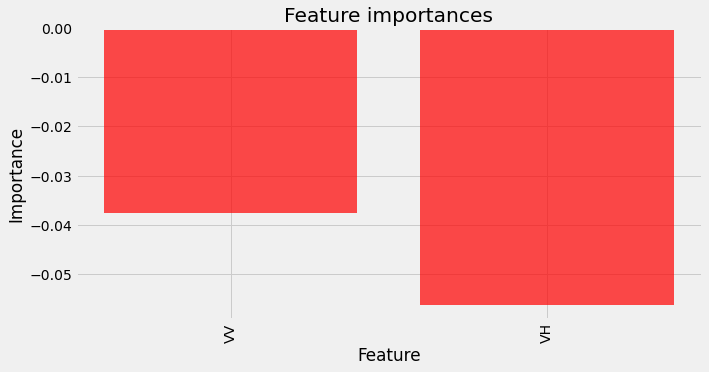

In [77]:
##### FEATURE IMPORTANCE Neural Network
##### n: controls the number of permutations per feature
y_pred = model.predict( X_test_CNN, verbose=1)

def get_feature_importance(j, n):
    #### Uso la metrica AUC
    fpr , tpr , thresholds = roc_curve ( y_test, y_pred) # baseline score
    s = auc(fpr, tpr)
    #### Uso la metrica Accuracy
#     results = model.evaluate(X_test_CNN, y_test)
#     s = results[1] # baseline score
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(X_test_CNN.shape[0]))
        X_test_ = X_test_CNN.copy()
        X_test_[:,:,:,j] = X_test[perm,:,:,j]
        #### Uso la metrica AUC
        y_pred_ = model.predict(X_test_)
        fpr_ , tpr_ , thresholds_ = roc_curve ( y_test, y_pred_)
        s_ij = auc(fpr_, tpr_)
        #### Uso la metrica Accuracy
#         results_ = model.evaluate(X_test_, y_test)
#         s_ij = results_[1]
        total += s_ij
    return s - total / n #abs(s - total / n)


n_bands = X_test_CNN.shape[-1]
f = []
for j in range(n_bands) :
    f_j = get_feature_importance(j, 10)
    f.append(f_j)# Plot

plt.figure(figsize=(10, 5))
plt.bar(range(n_bands), f, color="r", alpha=0.7)
plt.xticks(ticks=range(n_bands), labels=[bands[b] for b in best_bands], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

# Modello Australiano

- example of heatmap generationg https://github.com/heuritech/convnets-keras/blob/master/convnetskeras/convnets.py

In [78]:
import tensorflow_addons as tfa
from keras.regularizers import L1L2, l2, l1, l1_l2

model_name = 'australian'

activity_l1 = L1L2(l1=1)
activity_l2 = L1L2(l2=1)
activity_l1l2 = l1_l2(l1=1,l2=1)

def get_model(input_shape, batch_norm=True, activation='relu', border_mode='same', channels = 14*5, l1=0, l2=0):
    
    def activation_f(activation=activation):
        if isinstance(activation, str):
            return activation
        else:
            return activation()
    def reg(l1,l2):
        return dict(
            kernel_regularizer=l1_l2(l1,l2),
            bias_regularizer=l1_l2(l1,l2),
            #activity_regularizer=activity_l1l2(l1,l2)
        )
    model = Sequential()
    batch_input_shape=(None, X_train.shape[1], X_train.shape[2], X_train.shape[3])
    model.add(InputLayer(input_shape=input_shape, name='input'))
    model.add(Permute((2,3,1)))
    
    model.add(Convolution2D(channels,1,1,padding=border_mode,**reg(l1,l2)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation_f()))

    pooling = 5
    model.add(Convolution2D(filters=channels,kernel_size=(pooling,pooling),padding=border_mode,strides=(pooling, pooling),**reg(l1,l2)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation_f()))
    
    model.add(Convolution2D(filters=channels,kernel_size=(1,1),padding=border_mode,**reg(l1,l2)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation_f()))
    
    pooling = 5
    model.add(Convolution2D(filters=channels*2,kernel_size=(pooling,pooling),padding=border_mode,strides=(pooling, pooling),**reg(l1,l2)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation_f()))
    
    model.add(Convolution2D(filters=channels,kernel_size=(1,1),padding=border_mode,**reg(l1,l2)))
    if batch_norm: model.add(BatchNormalization())
    model.add(Activation(activation_f()))
    
    model.add(Convolution2D(filters=1,kernel_size=(1,1),padding=border_mode,**reg(l1,l2)))
    model.add(Flatten())
    model.add(Activation('sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer='nadam', metrics=['accuracy'])
    
    return model

model = get_model(input_shape, 
                  border_mode='same',
                  activation=keras.layers.advanced_activations.LeakyReLU, 
                  batch_norm=True, 
                  channels=input_shape[-1]*3,
                  l1=0.01/5, 
                  l2=0.01/5
                 )

model.compile(loss='binary_crossentropy',optimizer='nadam', metrics=['accuracy'])
model.summary()

weights_file = outdir.joinpath(model_name+'_weights.h5')
model_file = outdir.joinpath(model_name+'_model.h5')

image_data_gen_params=dict(
    #     featurewise_center=True,
    #     featurewise_std_normalization=True,
        channel_shift_range=0.08,
        rotation_range=10,
        width_shift_range=0.08,
        height_shift_range=0.08,
        horizontal_flip=True,
        vertical_flip=True,
       #dim_ordering='th',
        rescale=0.30,
    #     zoom_range=0.05,
    #     shear_range=0.05,
)

datagen = ImageDataGenerator(**image_data_gen_params)

try:
    model.load_weights(weights_file)
    print("Modello già calcolato e disponibile")
except:
    history = model.fit(
        datagen.flow(X_train_CNN, y_train, batch_size=batch_size),
        steps_per_epoch=len(X_train_CNN)//batch_size,
        verbose=0, 
        epochs=60, 
        validation_data=[X_val_CNN,y_val],
        callbacks=[
            tfa.callbacks.TQDMProgressBar(),
            keras.callbacks.EarlyStopping(patience=6, monitor='loss', verbose=1),
            keras.callbacks.EarlyStopping(patience=6, monitor='val_loss', verbose=1),
            keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=3, verbose=1),
            keras.callbacks.ModelCheckpoint(weights_file, save_best_only=True),
    #         keras.callbacks.CSVLogger(output_dir.joinpath('log-%s.log'%ts)),
    #         keras.callbacks.TensorBoard(log_dir=output_dir),
        ]
    )
    pd.DataFrame(history.history).plot()

    #Recall saved weight 
    model.load_weights(weights_file)
    model.save(model_file)

score = model.evaluate(X_val_CNN, y_val, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 permute (Permute)           (None, 25, 2, 25)         0         
                                                                 
 conv2d_130 (Conv2D)         (None, 25, 2, 6)          156       
                                                                 
 batch_normalization_108 (Ba  (None, 25, 2, 6)         24        
 tchNormalization)                                               
                                                                 
 activation_2 (Activation)   (None, 25, 2, 6)          0         
                                                                 
 conv2d_131 (Conv2D)         (None, 5, 1, 6)           906       
                                                                 
 batch_normalization_109 (Ba  (None, 5, 1, 6)          24        
 tchNormalization)                                   

13/13 [==============================] - 0s 1ms/step


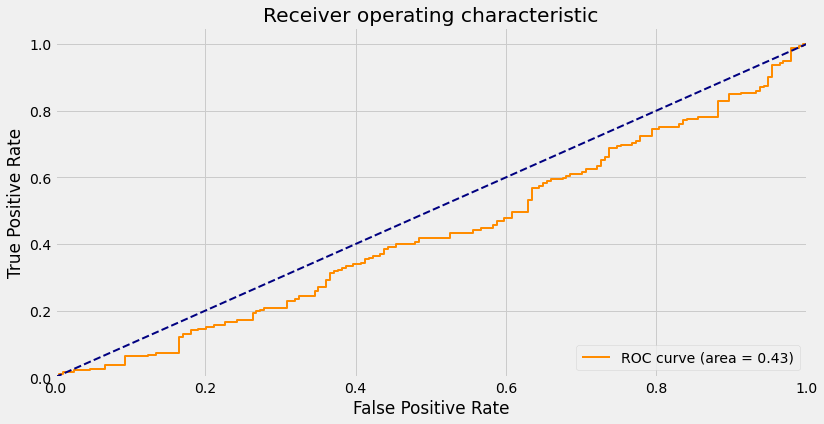

In [79]:
y_pred = model.predict(X_test_CNN, verbose=1)

fpr , tpr , thresholds = roc_curve ( y_test, y_pred)
roc_auc = auc(fpr, tpr)
if len([model_list.index(i) for i in model_list if 'model_'+model_name in i ]) > 0 :
    model_list.pop([model_list.index(i) for i in model_list if 'model_'+model_name in i ][0])
model_list.append(['model_'+model_name,roc_auc])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

13/13 [==============================] - 0s 1ms/step


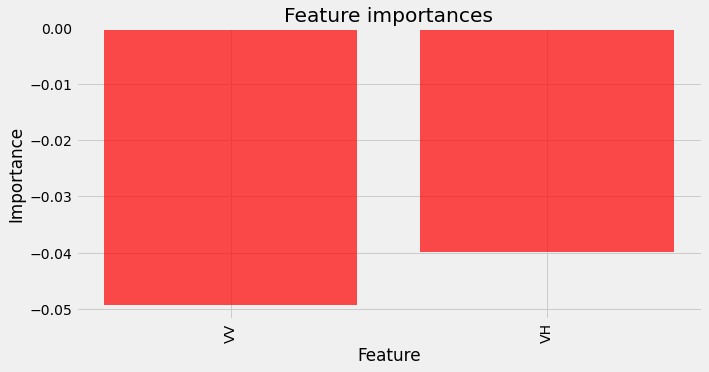

In [80]:
##### FEATURE IMPORTANCE Neural Network
##### n: controls the number of permutations per feature
y_pred = model.predict( X_test_CNN, verbose=1)

def get_feature_importance(j, n):
    #### Uso la metrica AUC
    fpr , tpr , thresholds = roc_curve ( y_test, y_pred) # baseline score
    s = auc(fpr, tpr)
    #### Uso la metrica Accuracy
#     results = model.evaluate(X_test_CNN, y_test)
#     s = results[1] # baseline score
    total = 0.0
    for i in range(n):
        perm = np.random.permutation(range(X_test_CNN.shape[0]))
        X_test_ = X_test_CNN.copy()
        X_test_[:,:,:,j] = X_test[perm,:,:,j]
        #### Uso la metrica AUC
        y_pred_ = model.predict(X_test_)
        fpr_ , tpr_ , thresholds_ = roc_curve ( y_test, y_pred_)
        s_ij = auc(fpr_, tpr_)
        #### Uso la metrica Accuracy
#         results_ = model.evaluate(X_test_, y_test)
#         s_ij = results_[1]
        total += s_ij
    return s - total / n #abs(s - total / n)


n_bands = X_test_CNN.shape[-1]
f = []
for j in range(n_bands) :
    f_j = get_feature_importance(j, 10)
    f.append(f_j)# Plot

plt.figure(figsize=(10, 5))
plt.bar(range(n_bands), f, color="r", alpha=0.7)
plt.xticks(ticks=range(n_bands), labels=[bands[b] for b in best_bands], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature importances")
plt.show()

In [81]:
# y_true = y_test
# target_names = ['no leak','leak']
# np.array([y_pred.T[0].T,y_true]).T[:10]

# Test pictures

17ODL304922
[1671, 2567]
Leak: False


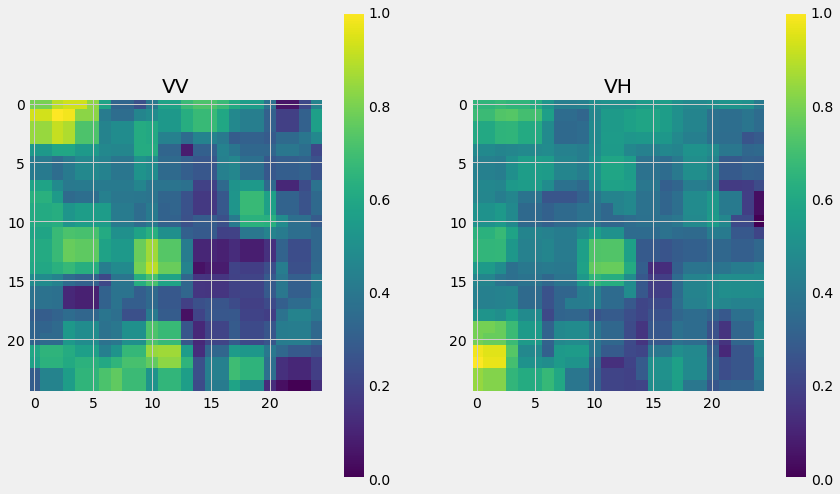

Leak: True


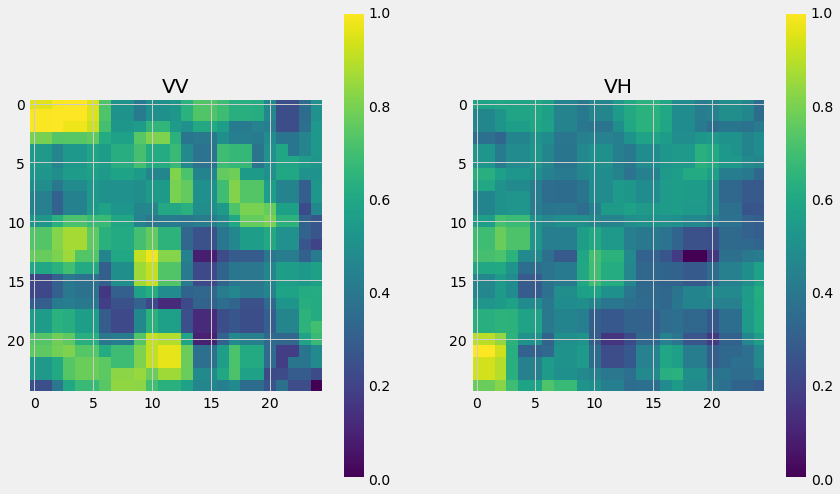

In [82]:
def show_images(images: [np.ndarray], titles = [], size = (20,20), r: int = 0, c: int = 0):
    n: int = len(images)
    f = plt.figure(figsize=size)
    for i in range(n):
        if r > 0 and c > 0 :
            ax = f.add_subplot( r, c, i + 1)
        elif r > 0:
            ax = f.add_subplot( r, int(len(images)/r)+1, i + 1)
        elif c > 0:
            ax = f.add_subplot( int(len(images)/c)+1, c, i + 1)
        else:
            ax = f.add_subplot( int(len(images)/3)+1, 3, i + 1)
        ax.set_title(titles[i])
        im = ax.imshow(images[i])
        f.colorbar(im, ax=ax)
    plt.show(block=True)


index_wo_list = []
wonum = metadatas[-1]['leak']['features'][0]['properties']['metadata']['wonum']
print(wonum)

for w in range(len(metadatas)):
    wo = metadatas[w]['leak']['features'][0]['properties']['metadata']['wonum']
    if wo == wonum:
        index_wo_list.append(w)
print(index_wo_list)

for id_wo in index_wo_list:
    img_0 = []
    l = y_raw[id_wo]
    print("Leak:",l)
    for b in range(X_raw[id_wo].shape[0]):
        img_b = X_raw[id_wo,b,:,:]
        if img_b.min()==img_b.max()==0:
            pass
        else:
            b_norm = (img_b-img_b.min())/(img_b.max()-img_b.min())
            img_0.append(b_norm)

    show_images(img_0, titles=[bands[b] for b in best_bands], size = (20,8))

# comb_list = list(itertools.combinations([bands[b] for b in best_bands],3))

# img_set = []
# for j, comb in enumerate(comb_list):
#     img_set.append(
#         np.transpose(
#             np.array(  
#                 [
#                     img_0[[bands[b] for b in best_bands].index(comb[0])],
#                     img_0[[bands[b] for b in best_bands].index(comb[1])],
#                     img_0[[bands[b] for b in best_bands].index(comb[2])] 
#                 ]
#             )
#         )[:,:,::-1]
#     )

# print("Leak:",y_test[id_data])
# show_images(img_set, titles=comb_list, size = (20,20) )

# Dummy model test

this gives the base case. The trivial level of accuracy

In [83]:
df,best = find_best_dummy_classification(X_temp,y_temp, n=15)

df[:5]

C:\Users\tranfa.carmine\Anaconda3\envs\satellite\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tranfa.carmine\Anaconda3\envs\satellite\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tranfa.carmine\Anaconda3\envs\satellite\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

C:\Users\tranfa.carmine\Anaconda3\envs\satellite\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tranfa.carmine\Anaconda3\envs\satellite\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tranfa.carmine\Anaconda3\envs\satellite\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

C:\Users\tranfa.carmine\Anaconda3\envs\satellite\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tranfa.carmine\Anaconda3\envs\satellite\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\tranfa.carmine\Anaconda3\envs\satellite\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

strategy  matthews_corrcoef     score  \
87  classifier_stratified           0.066417  0.474708   
63  classifier_stratified           0.066372  0.499351   
69  classifier_stratified           0.061139  0.501946   
85     classifier_uniform           0.047934  0.505837   
15  classifier_stratified           0.032306  0.522698   

                                               report  
87                precisio  n    recal  l  f1-scor...  
63                precisio  n    recal  l  f1-scor...  
69                precisio  n    recal  l  f1-scor...  
85                precisio  n    recal  l  f1-scor...  
15                precisio  n    recal  l  f1-scor...

# Map and view

##  View on map: fp, fn, tp, tn

Lets view the false positives on the map to see what can cause them

- false negatives: look like we miss some in the town when the pipe is obscured, but it's ok on lawn, parks, streetsides
- false positive: near water e.g. river, pool (or repairs that say "tmp" so maybe I should not include these)

In [84]:
model_df = pd.DataFrame(model_list, columns=columns)

model_df.to_csv(outdir.joinpath('models_score.csv'))
model_df.to_excel(outdir.joinpath('models_score.xlsx'))

model_df.sort_values('aoc', ascending=False)

model_name       aoc
4          model_vgg  0.564540
1           model_AB  0.507786
0           model_RF  0.494295
5        model_vgg16  0.478670
2           model_GB  0.466696
7     model_resnet18  0.456561
6      model_statoil  0.443339
10  model_australian  0.431970
9        model_u_net  0.431902
8     model_densenet  0.425983
3           model_ET  0.293465

In [85]:
if os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD':
    best_cnn_name = 'statoil'
    best_cnn_model = tf.keras.models.load_model(outdir.joinpath(best_cnn_name + '_model.h5'))
    best_cnn_model.load_weights(outdir.joinpath(best_cnn_name + '_weights.h5'))

    best_ensamble_model = model_ET
    best_model = best_ensamble_model
elif os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD_FLOAT':
    best_cnn_name = 'densenet'
    best_cnn_model = tf.keras.models.load_model(outdir.joinpath(best_cnn_name + '_model.h5'))
    best_cnn_model.load_weights(outdir.joinpath(best_cnn_name + '_weights.h5'))

    best_ensamble_model = model_ET
    best_model = best_ensamble_model
elif os.path.split(data_path)[-1] == 'COPERNICUS_S2':
    best_cnn_name = 'resnet18'
    best_cnn_model = tf.keras.models.load_model(outdir.joinpath(best_cnn_name + '_model.h5'))
    best_cnn_model.load_weights(outdir.joinpath(best_cnn_name + '_weights.h5'))

    best_ensamble_model = model_GB
    best_model = best_cnn_model
elif os.path.split(data_path)[-1] == 'COPERNICUS_S2_SR':
    best_cnn_name = 'resnet18'
    best_cnn_model = tf.keras.models.load_model(outdir.joinpath(best_cnn_name + '_model.h5'))
    best_cnn_model.load_weights(outdir.joinpath(best_cnn_name + '_weights.h5'))

    best_ensamble_model = model_GB
    best_model = best_cnn_model

In [86]:
color_dict = {
        'fn':'orange', # fn
        'fp':'red', # fp
        'tn':'blue', # tn
        'tp':'green' # tp
        }

def rgb_to_hex(red, green, blue, alpha=1.0):
    """Return color as #rrggbb for the given color values."""
    return '#%02x%02x%02x' % (int(red*alpha), int(green*alpha), int(blue*alpha))

def color(x):
    """calc color for a row based on result class and confidence"""
    color_dict = {
            'fn': [197, 66, 244], # fn
            'fp': [244, 66, 66], # fp
            'tn': [66, 78, 244], # tn
            'tp': [66, 244, 75] # tp
            }
    rgba=color_dict[x['result_class']]+[x['confidence']]
    return rgb_to_hex(*rgba)

In [87]:
y_pred_bem = best_ensamble_model.predict_proba(X_test_ensemble)[:,1]
y_true = y_test
mds = metadata_test

# make a dataframe of results
geojson_bem = [d['leak']['features'][0] for d in mds]
gdf_bem = gpd.GeoDataFrame.from_features(geojson_bem, crs='epsg:4326')

# add stats
gdf_bem['y_pred']=y_pred_bem
gdf_bem['y_true']=y_true
gdf_bem['confidence']=np.abs(y_pred_bem-0.5)*2
gdf_bem['result_class']=calculate_result_class(y_pred_bem, y_true, words=True)

# calculate time in days
tss = []
for md in mds:
    t_image = arrow.get(md['image']['properties']['system:time_start']/1000)
    t_leak = arrow.get(md['leak']['features'][0]['properties']['reportdate'])
    td=t_image-t_leak
    tss.append(td.total_seconds()/(60*60*24))
gdf_bem['image_time_days'] = tss
gdf_bem['image_date'] = [arrow.get(md['image']['properties']['system:time_start']/1000).format() for md in mds]

gdf_bem['marker-color']=gdf_bem.apply(color,axis=1)

In [88]:
try:
    y_pred_bcm = best_cnn_model.predict(X_test_CNN)[:,0]
except:
    y_pred_bcm = best_cnn_model.predict([X_test_CNN,X_dati_test])[:,0]

y_true = y_test
mds = metadata_test

# make a dataframe of results
geojson_bcm = [d['leak']['features'][0] for d in mds]
gdf_bcm = gpd.GeoDataFrame.from_features(geojson_bcm, crs='epsg:4326')

# addd stats
gdf_bcm['y_pred']=y_pred_bcm
gdf_bcm['y_true']=y_true
gdf_bcm['confidence']=np.abs(y_pred_bcm-0.5)*2
gdf_bcm['result_class']=calculate_result_class(y_pred_bcm, y_true, words=True)

# calculate time in days
tss = []
for md in mds:
    t_image = arrow.get(md['image']['properties']['system:time_start']/1000)
    t_leak = arrow.get(md['leak']['features'][0]['properties']['reportdate'])
    td=t_image-t_leak
    tss.append(td.total_seconds()/(60*60*24))
gdf_bcm['image_time_days'] = tss
gdf_bcm['image_date'] = [arrow.get(md['image']['properties']['system:time_start']/1000).format() for md in mds]

gdf_bcm['marker-color']=gdf_bcm.apply(color,axis=1)

In [89]:
# view on maps
import folium
location = [44.149987829381445, 9.98337790677243]

# choose properties to show on the map popup
prop_map = ['workorderid','reportdate',
            'y_pred','y_true','confidence',
            'result_class','image_time_days']

print("Modello NN")
samples = gdf_bcm.sample(min(len(gdf_bcm),1000)) # top 100 dei risultati
map_osm = folium.Map(location=location, tiles="cartodbpositron", zoom_start=10, max_zoom=12, min_zoom=0.1)

results_feature_g=dict()
for g in ['fp','fn','tn','tp']:
        results_feature_g[g] = folium.FeatureGroup(name=g)

for i in (range(len(samples))):
    x = samples.iloc[i]
    xx=x[prop_map]
    fgroup = results_feature_g[xx['result_class']]
    folium.Marker(
            np.array(x.geometry.xy).T[0][::-1].tolist(),
            popup=folium.Popup(xx.to_frame().to_html(), width=500, height=300, max_width=2650),
            icon=folium.Icon(color=color_dict[x['result_class']],icon_color=x['marker-color'])
             ).add_to(fgroup)

for g in ['fp','fn','tn','tp']:
    results_feature_g[g].add_to(map_osm)

folium.LayerControl().add_to(map_osm)
display(map_osm)


print("Modello Ensemble")
samples = gdf_bem.sample(min(len(gdf_bem),1000)) # top 100 dei risultati
map_osm = folium.Map(location=location, tiles="cartodbpositron", zoom_start=10, max_zoom=12, min_zoom=0.1)

results_feature_g=dict()
for g in ['fp','fn','tn','tp']:
        results_feature_g[g] = folium.FeatureGroup(name=g)

for i in (range(len(samples))):
    x = samples.iloc[i]
    xx=x[prop_map]
    fgroup = results_feature_g[xx['result_class']]
    folium.Marker(
            np.array(x.geometry.xy).T[0][::-1].tolist(),
            popup=folium.Popup(xx.to_frame().to_html(), width=500, height=300, max_width=2650),
            icon=folium.Icon(color=color_dict[x['result_class']],icon_color=x['marker-color'])
             ).add_to(fgroup)

for g in ['fp','fn','tn','tp']:
    results_feature_g[g].add_to(map_osm)

folium.LayerControl().add_to(map_osm)
display(map_osm)

Modello NN


Modello Ensemble


## Make a prediction

Here we download a recent satellite image and then make predictions where pipes cross.

In [90]:
crs_grid = 3857
satellite = script_metadata['satellite']
resolution_min = script_metadata['resolution_min']
distance = 3000
pixel_length = int(distance/resolution_min)

In [91]:
# Trasformo il dataframe con unità metriche
geojson = [d['leak']['features'][0] for d in metadatas]
gdf_leak = gpd.GeoDataFrame.from_features(geojson, crs='epsg:4326')

# Lista dei workorderid
wo = gdf_leak['workorderid']
list_wo = []
for w in wo:
    list_wo.append([
        w,
        gdf_leak.loc[gdf_leak["workorderid"]==w]["metadata"].iloc[0]["comune"].upper(),
        gdf_leak.loc[gdf_leak["workorderid"]==w]["metadata"].iloc[0]["via"].upper(),
        gdf_leak.loc[gdf_leak["workorderid"]==w]["metadata"].iloc[0]["anno"],
                ])
wo_df = pd.DataFrame(list_wo, columns= ["workorderid","comune","via","anno"])

if os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD':
    dict_loc = {"nome":['MASSA CENTRO'], 
                "comune":['MASSA'], 
                "via":['FRANGOLA']}
elif os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD_FLOAT':
    dict_loc = {"nome":['MASSA CENTRO','ROTAIO','FRASCALINO',
                          'CAPEZZANO-CAPRIGLIA','VIAREGGIO-LIDO','FORTE DEI MARMI',
                          'CAMAIORE CENTRO'], 
                "comune":['MASSA','CAMAIORE','CAMAIORE',
                          'PIETRASANTA','CAMAIORE','FORTE DEI MARMI',
                          'CAMAIORE'], 
                "via":['TRIESTE','ARGIN','FRASCALINO',
                      'CANAL','DEL SECCO','CARRARA',
                      'SETTEMBRE']}
elif os.path.split(data_path)[-1] == 'COPERNICUS_S2':
    dict_loc = {"nome":['MASSA CENTRO'],
                "comune":['MASSA'], 
                "via":['PALESTRO']}
elif os.path.split(data_path)[-1] == 'COPERNICUS_S2_SR':
    dict_loc = {"nome":['MASSA CENTRO'],
                "comune":['MASSA'], 
                "via":['FRANGOLA']}


dict_geom = {"nome":[],"workorderid":[],"geom":[]}

for i in range(len(dict_loc["nome"])):
    wo_id = wo_df.loc[wo_df["comune"]==dict_loc['comune'][i]].loc[wo_df["via"].str.contains(dict_loc['via'][i])]['workorderid'].iloc[0]
    point = gdf_leak.loc[gdf_leak["workorderid"]==wo_id]["geometry"].iloc[0]
    dict_geom["nome"].append(dict_loc["nome"][i])
    dict_geom["workorderid"].append(wo_id)
    dict_geom["geom"].append(point)

nome_punto = 'MASSA CENTRO'
wo_id = dict_geom["workorderid"][dict_loc['nome'].index(nome_punto)]
point = dict_geom["geom"][dict_loc['nome'].index(nome_punto)]
print(nome_punto, point)

temp_dir = cache_dir = Path("..\\output\\temp")

import folium
location = (point.xy[1][0],point.xy[0][0])
map_odl = folium.Map(location=location, tiles="cartodbpositron", zoom_start=18, max_zoom=22, min_zoom=14)
folium.Marker(location).add_to(map_odl)
display(map_odl)

MASSA CENTRO POINT (10.138034709458369 44.046172535530644)


In [92]:
# wo_df = wo_df.loc[wo_df["comune"]=='MASSA'].loc[wo_df["via"].str.contains('TRIESTE')] #Massa Centro

#### Download recent sat image

In [93]:
# find latest image
import ee
ee.Initialize() # should give no errors, if so follow instructions

# get boundary to crop/search image with
boundary = get_boundary(gdf_leak.loc[gdf_leak["workorderid"]==wo_id], distance=distance)


if os.path.split(data_path)[-1] in ('COPERNICUS_S1_GRD','COPERNICUS_S1_GRD_FLOAT'):
    print("satellite Sentinel-1 SAR")
    satellite_img = (ee.ImageCollection(satellite)
                    .filterBounds(boundary)
                    #.filter(ee.Filter.eq('orbitProperties_pass', orbit_type0 ))
                    .filter(ee.Filter.eq('relativeOrbitNumber_start', orbit_number0 ))
                    #.filterDate(arrow.get('2021/12/01 00:00:00').timestamp()*1000, # test
                    #            arrow.get('2022/01/20 00:00:00').timestamp()*1000) # test
                    .sort('system:time_start', opt_ascending=False)
                   )
    image = ee.Image(satellite_img.first())
    orbit_type = image.getInfo()['properties']['orbitProperties_pass']
    orbit_number = image.getInfo()['properties']['relativeOrbitNumber_start']
    print(orbit_type, orbit_number)
    satellite_img = (ee.ImageCollection(satellite)
                    .filterBounds(boundary)
                    .filter(ee.Filter.eq('orbitProperties_pass', orbit_type))
                    .filter(ee.Filter.eq('relativeOrbitNumber_start', orbit_number))
                    .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
                    #.filterDate(arrow.get('2021/12/01 00:00:00').timestamp()*1000, # test
                    #            arrow.get('2022/01/20 00:00:00').timestamp()*1000) # test
                    .sort('system:time_start', opt_ascending=False)
                   )
    img_list = [image]
    
elif os.path.split(data_path)[-1] in ('COPERNICUS_S2','COPERNICUS_S2_SR'):
    print("satellite Sentinel-2")
    satellite_img = (ee.ImageCollection(satellite)
                    .filterBounds(boundary)
                    #.filterDate(arrow.get('2021/05/01 00:00:00').timestamp()*1000,
                    #            arrow.get('2021/07/30 00:00:00').timestamp()*1000)
                     .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',0.1)
                     .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
                     .sort('system:time_start', opt_ascending=False)
                   )
    assert satellite_img.size().getInfo()>0,' oh no, no image results'
    image = ee.Image(satellite_img.first()).clip(boundary)
    img_list = [image]

else:
    print("Nessun satellite")
    satellite_img = None
    
if os.path.split(data_path)[-1] in ('COPERNICUS_S1_GRD_FLOAT'):
    im_list = satellite_img.toList(satellite_img.size())
    image = ee.Image(satellite_img.first()).clip(boundary)
    img_t0 = ee.Image(im_list.get(0)).clip(boundary)
    img_t1 = ee.Image(im_list.get(1)).clip(boundary)
    img_list = [img_t0, img_t1]

info = image.getInfo()
data_img = arrow.get(info['properties']['system:time_start']/1000)
print("Data immagine",data_img)

satellite_srtm = 'USGS/SRTMGL1_003'
srtm_img = ee.Image(satellite_srtm)
elevation = srtm_img.clip(boundary)
slope = ee.Terrain.slope(srtm_img).clip(boundary)
img_list.extend([elevation,slope])

if os.path.split(data_path)[-1] in ('COPERNICUS_S2','COPERNICUS_S2_SR'):
    print("Nuvolosità immagine",info['properties']['CLOUDY_PIXEL_PERCENTAGE'])
info

satellite Sentinel-1 SAR
DESCENDING 168
Data immagine 2022-04-02T05:27:47+00:00


{'type': 'Image',
 'bands': [{'id': 'VV',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [438, 437],
   'origin': [15012, 15003],
   'crs': 'EPSG:32632',
   'crs_transform': [10, 0, 438861.48022850475, 0, -10, 5029844.685327236]},
  {'id': 'VH',
   'data_type': {'type': 'PixelType', 'precision': 'double'},
   'dimensions': [438, 437],
   'origin': [15012, 15003],
   'crs': 'EPSG:32632',
   'crs_transform': [10, 0, 438861.48022850475, 0, -10, 5029844.685327236]},
  {'id': 'angle',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [2, 1],
   'origin': [8, 6],
   'crs': 'EPSG:32632',
   'crs_transform': [-13097.621689479449,
    -3251.879500619252,
    728194.7672922602,
    2069.2949822172523,
    -20123.79671047628,
    4984514.068724521]}],
 'id': 'COPERNICUS/S1_GRD/S1A_IW_GRDH_1SDV_20220402T052747_20220402T052812_042590_0514A4_E9F5',
 'version': 1649686477091125,
 'properties': {'date': '20220402',
  'GRD_Post_Processing_star

In [94]:
# satellite_img = (ee.ImageCollection(satellite)
#                 .filterBounds(boundary)
#                 .filterDate(arrow.get('2021/12/01 00:00:00').timestamp()*1000,
#                             arrow.get('2022/01/09 00:00:00').timestamp()*1000)
#                 .sort('system:time_start', opt_ascending=False)
#                )
# image = ee.Image(satellite_img.first()).clip(boundary)
# info = image.getInfo()
# data_img = arrow.get(info['properties']['system:time_start']/1000)
# print(data_img)
# info

In [95]:
# ######### Lista immagni nell'intervallo
# timestamplist = (satellite_img.aggregate_array('date')
#                  .map(lambda d: ee.String('T').cat(ee.String(d)))
#                  .getInfo())
# timestamplist[:10]

In [96]:
import shutil
folder_name = arrow.get(info["properties"]["system:time_start"]/1000).format('YYYYMMDD-HH-mm-ss')

for i in temp_dir.listdir():
    try:
        shutil.rmtree(i)
    except Exception as e:
        print(e)

for i in img_list:
    path, files=download_image(
        i,
        scale=resolution_min,
        crs=crs_grid,
        name=folder_name,
        cache_dir = temp_dir,
        report=True
    )

with open(path.joinpath('metadata.json'), 'w') as fo:
    metadata = dict(
        image=image.getInfo(),
        scale=resolution_min,
        crs=crs_grid,
        name=folder_name,
        distance=distance,
        leak=None
    )
    json.dump(metadata, fo)

files = [file.relpath(path) for file in path.listdir() if file.endswith('.tif')]

print(path)
print('\n'.join(files))

3c22c0cac08096f49a8b6fa1f31a6d1a-8e482a3: 3.88MB [00:03, 1.09MB/s]                            
39e56e58a77f21c24c591585fbcf8e3d-1abf34e: 3.87MB [00:03, 978kB/s]                             
fdce0b6aea10f5fef773ab909ee33582-024f5dd: 49.2kB [00:01, 41.4kB/s]                            
c95634f0fe0021c9eb595c86c172af95-a8a09d5: 106kB [00:01, 75.9kB/s]                            


..\output\temp\20220402-05-27-47_3857_10.0
download.slope.tif
S1A_IW_GRDH_1SDV_20220321T052746_20220321T052811_042415_050EB8_8561.angle.tif
S1A_IW_GRDH_1SDV_20220321T052746_20220321T052811_042415_050EB8_8561.VH.tif
S1A_IW_GRDH_1SDV_20220321T052746_20220321T052811_042415_050EB8_8561.VV.tif
S1A_IW_GRDH_1SDV_20220402T052747_20220402T052812_042590_0514A4_E9F5.angle.tif
S1A_IW_GRDH_1SDV_20220402T052747_20220402T052812_042590_0514A4_E9F5.VH.tif
S1A_IW_GRDH_1SDV_20220402T052747_20220402T052812_042590_0514A4_E9F5.VV.tif
SRTMGL1_003.elevation.tif


In [100]:
metadata = json.load(open(path.joinpath('metadata.json')))
bands = script_metadata['bands']

if os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD_FLOAT':
    files_0 = files[3:]
    print(files_0)
    data_raw0 = tifs2np(path, files_0, bands=bands).astype('float64')
    
    files_1 = files[:3]
    print(files_1)
    data_raw1 = tifs2np(path, files_1, bands=bands).astype('float64')
    
    #bands = ['VV/VV', 'VV', 'VH/VH', 'VH', 'angle/angle']
    data_raw = np.zeros(shape=(data_raw0.shape))
    data_raw[(0,2,4),:,:] = data_raw0[(0,2,4),:,:]/data_raw1[(0,2,4),:,:]
    data_raw[(1,3),:,:] = data_raw0[(0,2),:,:]
    data_raw = 10*np.log(data_raw)
else:
    data_raw = tifs2np(path,files,bands=bands).astype('float64')

data = data_raw[[b for b in best_bands]]

print(data.shape)
data_detail = []
for b in range(data.shape[0]):
    data_detail.append([bands[best_bands[b]],data[b].min(),data[b].max(), np.count_nonzero(data[b])])

data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
print(data_detail)

(2, 601, 601)
  Banda        Min        Max  Non Zero
0    VV -28.145915  19.469420    361200
1    VH -35.435519   6.628137    361200


In [ ]:
# ###### Test che l'immagine venga riportata correttamente

# lx = data.shape[1]
# ly = data.shape[2]

# data_test = np.zeros(shape=data.shape)

# for b in range(data.shape[0]):
#     for i in range(int(lx/2)):
#         for j in range(int(ly/2)):
#             data_test[b,i,j] = data[b,i,j]

# data = data_test

# print(data.shape)
# data_detail = []
# for b in range(data.shape[0]):
#     data_detail.append([bands[best_bands[b]],data[b].min(),data[b].max(), np.count_nonzero(data[b])])

# data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
# print(data_detail)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image taken at 2022-04-02 07:27:47+02:00
-0.5011195395390583 1.7024416203702175 0.44642345660635674
-0.5638938880873902 1.43858793231456 0.4560851475555636
-0.39098077082573773 1.9856173426041115 0.4260103528236631
Immagine RGB


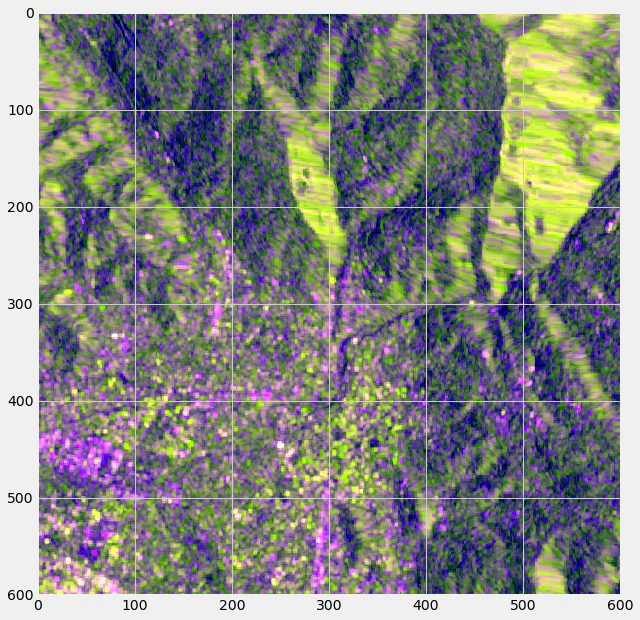

In [108]:
############ view sat image for QC
from matplotlib.colors import Normalize 

image_time = arrow.get(info['properties']['system:time_end']/1000)
print('image taken at', image_time.to('Europe/Rome').format())

best_bands_name = [bands[b] for b in best_bands]

if os.path.split(data_path)[-1]  == 'COPERNICUS_S1_GRD' :
#     #im_sat = data[(0,2,4),:,:].copy() #filtro per Sentinel-1
#     im_sat = np.zeros((3,data.shape[1],data.shape[2]))
#     for b in range(data.shape[0]):
#         im_sat[b] = data[b]
#     im_sat = np.transpose(im_sat,(1,2,0))[:,:,::-1]
    im_sat = np.zeros((data.shape[1],data.shape[2],3))
    if 'angle' in best_bands_name :
        for i, b in enumerate(['VV','VH','angle']): # equivalenti ad RGB
            im_sat[:,:,i] = data[best_bands_name.index(b)]
            im_sat[:,:,i] = (im_sat[:,:,i]-np.median(im_sat[:,:,i]))/im_sat[:,:,i].std() #prova di normalizzazione.
    else:
        im_sat = data[(bands.index('VV'),bands.index('VH')),:,:].copy()
        vv_vh = np.expand_dims(im_sat[0]-im_sat[1], axis=0) #VV/VH
        im_sat = np.concatenate((im_sat,vv_vh), axis=0)
        im_sat = np.transpose(im_sat,(1,2,0))
        for i in range(3):
            #im_sat[:,:,i] = (im_sat[:,:,i]-im_sat[:,:,i].min())/(im_sat[:,:,i].max()-im_sat[:,:,i].min())
            im_sat[:,:,i] = (im_sat[:,:,i]-np.quantile(im_sat[:,:,i],0.01))/(np.quantile(im_sat[:,:,i],0.99)-np.quantile(im_sat[:,:,i],0.01))
            print(im_sat[:,:,i].min(),im_sat[:,:,i].max(),im_sat[:,:,i].mean())

elif os.path.split(data_path)[-1] == 'COPERNICUS_S1_GRD_FLOAT' :
    im_sat = data[(bands.index('VV_num'),bands.index('VH_num')),:,:].copy() #filtro per Sentinel-1 GRD FLOAT (VV-VH)
    vv_vh = np.expand_dims(im_sat[0]/im_sat[1], axis=0) #VV/VH
    im_sat = np.concatenate((im_sat,vv_vh), axis=0)
    im_sat = np.transpose(im_sat,(1,2,0))
    for i in range(3):
        im_sat[:,:,i] = (im_sat[:,:,i]-im_sat[:,:,i].min())/(im_sat[:,:,i].max()-im_sat[:,:,i].min())
        #im_sat[:,:,i] = (im_sat[:,:,i]-np.quantile(im_sat[:,:,i],0.01))/(np.quantile(im_sat[:,:,i],0.99)-np.quantile(im_sat[:,:,i],0.01))
        #im_sat[:,:,i] = (im_sat[:,:,i]-im_sat[:,:,i].mean())/im_sat[:,:,i].std()
        print(im_sat[:,:,i].min(),im_sat[:,:,i].max(),im_sat[:,:,i].mean())
    
elif os.path.split(data_path)[-1] == 'COPERNICUS_S2' or os.path.split(data_path)[-1] == 'COPERNICUS_S2_SR':
    #im_sat = data[0:3,:,:].copy() #filtro per Sentinel-2 RGB
    # im_sat = np.transpose(im_sat,(1,2,0))[:,:,::-1]
    im_sat = np.zeros((data.shape[1],data.shape[2],3))
    for i, b in enumerate(['B4','B3','B2']): # equivalenti ad RGB
        im_sat[:,:,i] = data[best_bands_name.index(b)]
    im_sat = (im_sat/10).astype(int)

print("Immagine RGB")
plt.figure(figsize=(10,10))
plt.imshow(im_sat, interpolation='none')
plt.show()

if os.path.split(data_path)[-1] in ('COPERNICUS_S2','COPERNICUS_S2_SR'):
    print("Immagine Near Infrared")
    plt.figure(figsize=(10,10))
    plt.imshow(data[best_bands_name.index('B8')], interpolation='none')
    plt.show()

In [109]:
# Normalizzo i valori dell'immagine scaricata
for b in range(data.shape[0]):
    data[b,:,:] = (data[b,:,:]-norm_params[b][0])/norm_params[b][1]

print(data.shape)
data_detail = []
for b in range(data.shape[0]):
    data_detail.append([bands[best_bands[b]],data[b].min(),data[b].max(), np.count_nonzero(data[b])])

data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
print(data_detail)

(2, 601, 601)
  Banda       Min       Max  Non Zero
0    VV -5.495481  7.736815    361201
1    VH -5.649761  5.655709    361201


#### Filter pipes

In [110]:
%%time
# load pipe locations
import psycopg2 as pg

conn = pg.connect(host="",dbname="",user="",password="")
cur = conn.cursor() 
sql = """
select ra."location", ra.materiale, ra.diametro, ra.anno, ra.geom
from main.rete_adduzione ra 
union
select rd."location", rd.materiale, rd.diametro, rd.anno, rd.geom 
from main.rete_distribuzione rd
;
"""

pipes_df = gpd.GeoDataFrame.from_postgis(sql=sql, con=conn, geom_col="geom")
conn.close()

pipes_df=pipes_df.to_crs(epsg=crs_grid)

Wall time: 5.8 s


In [111]:
# filter pipes to ones inside the image
import shapely
# Trasformo in un SR metrico
import pyproj
from functools import partial
from shapely.ops import transform

# project = partial(
#     pyproj.transform,
#     pyproj.Proj(init="epsg:4326"), # source coordinate system
#     pyproj.Proj(init="epsg:3857")) # destination coordinate system

transformer = pyproj.Transformer.from_crs(
    "EPSG:4326", # source coordinate system
    "EPSG:3857", # destination coordinate system
    always_xy=True)

box = shapely.geometry.Polygon(info['properties']['system:footprint']['coordinates'][0])
box_4326 = shapely.geometry.Polygon(info['properties']['system:footprint']['coordinates'][0])

# box_crs_grid = transform(project, box_4326)
box_crs_grid = transform(transformer.transform, box_4326)

box = box_crs_grid

j=pipes_df.geometry.apply(lambda x:box.intersects(x))
pipes_intersecting = pipes_df[j]
pipes_intersecting

print('{:2.2%}'.format(len(pipes_intersecting)/len(pipes_df)))

3.36%


In [112]:
x0 = min(float(box.bounds[2]),float(box.bounds[0]))
y0 = min(float(box.bounds[3]),float(box.bounds[1]))
lx = max(float(box.bounds[2]),float(box.bounds[0]))-x0
ly = max(float(box.bounds[3]),float(box.bounds[1]))-y0
nx = data.shape[2] #non sono sicuro se 1 è x o y
ny = data.shape[1] #non sono sicuro se 2 è x o y
rx = lx/nx
ry = ly/ny

print("Coordinate iniziali:",x0, y0)
print("Numero pixel e risoluzione:",nx, ny, rx, ry)

Coordinate iniziali: 1125560.8615014388 5469590.27203594
Numero pixel e risoluzione: 601 601 9.983361064891847 9.983361064891847


In [113]:
from shapely import wkt
from shapely.geometry import LineString

def redistribute_vertices(geom, distance):
    """ Spezza le geometrie lineari ogni tot
        E' importante che l'unità di misura della distanza siano metri
        e che il sistema di riferimento delle tratte in ingresso sia sempre in metri
        P.E. EPSG: 25832 """
    if geom.geom_type == 'LineString':
        num_vert = int(round(geom.length / distance))
        if num_vert == 0:
            num_vert = 1
        return LineString(
            [geom.interpolate(float(n) / num_vert, normalized=True)
             for n in range(num_vert + 1)])
    elif geom.geom_type == 'MultiLineString':
        parts = [redistribute_vertices(part, distance)
                 for part in geom.geoms]
        return type(geom)([p for p in parts if not p.is_empty])
    else:
        raise ValueError('unhandled geometry %s', (geom.geom_type,))

  0%|          | 0/1869 [00:00<?, ?it/s]

points 19356


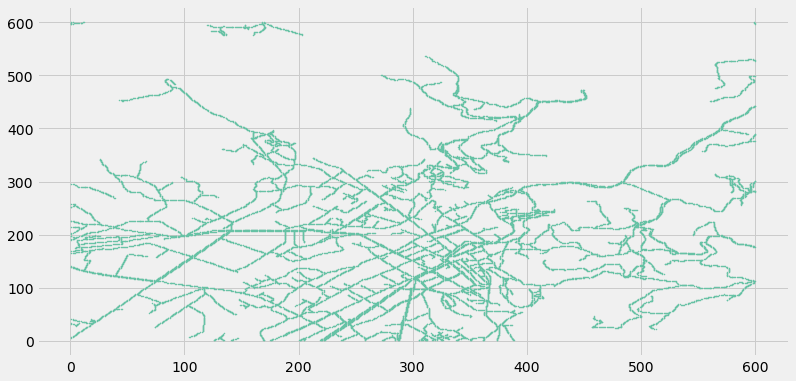

In [114]:
# interpolate pipes to the image
# for each pipe resample, then snap to  pixel coords, keep the unique coordinated in bouunds
ppcs=[]
for i in tqdm(range(len(pipes_intersecting))):
    pipe = pipes_intersecting.geometry.iloc[i]
    sub_pipe = redistribute_vertices(pipe,rx/2)
    if sub_pipe.geom_type=="LineString":
        for j in range(len(sub_pipe.coords)):
            # convert to pixel coords
            points_resampled = sub_pipe.coords[j]
            points_pc=((np.array((points_resampled[0], points_resampled[1])))-np.array([x0,y0]))/np.array([rx,ry])
            # then round
            points_pc=np.around(points_pc)
            ppcs.append([points_pc])
    if sub_pipe.geom_type=="MultiLineString":
        for k in range(len(sub_pipe.geoms)):
            for j in range(len(sub_pipe.geoms[k].coords)):
                # convert to pixel coords
                points_resampled = sub_pipe.geoms[k].coords[j]
                points_pc=((np.array((points_resampled[0], points_resampled[1])))-np.array([x0,y0]))/np.array([rx,ry])
                # then round
                points_pc=np.around(points_pc)
                ppcs.append([points_pc])

ppcs=np.concatenate(ppcs)

# also remove out of bounds ones
in_bounds = (ppcs[:,0]>0) * (ppcs[:,0]<data[0].shape[1]) * (ppcs[:,1]>0) * (ppcs[:,1]<data[0].shape[0])
ppcs=ppcs[in_bounds]

# remove dups
def unique_rows(a):
    order = np.lexsort(a.T)
    a = a[order]
    diff = np.diff(a, axis=0)
    ui = np.ones(len(a), 'bool')
    ui[1:] = (diff != 0).any(axis=1) 
    return a[ui]
ppcs=unique_rows(ppcs)

ppcs = ppcs.astype(int)
print('points',len(ppcs))

plt.scatter(ppcs[:,0],ppcs[:,1],s=1)
ppcs_raw = ppcs

In [ ]:
### Test per capire la rotazione
# img_base = img_base[0]
# plt.imshow(img_base, vmin=0 , vmax=1 )
# plt.colorbar()
# plt.show()

# img_test = data[:,::-1][0]
# plt.imshow(img_test, vmin=0 , vmax=1 )
# plt.colorbar()
# plt.show()

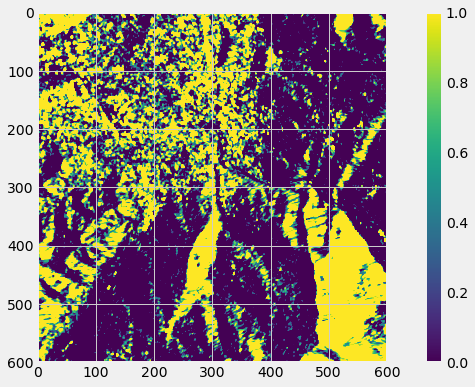

(2, 601, 601)
  Banda       Min       Max  Non Zero
0    VV -5.495481  7.736815    361201
1    VH -5.649761  5.655709    361201


In [115]:
### Il punto (0,0) delle reti segmentate è in basso a sx, nelle immagini da satellite è in alto a sx
### Bisogna ruotare le immagini scaricate in modo che durante l'intersezione vengano presi i box corretti

data = data[:,::-1]

plt.imshow(data[0], vmin=0 , vmax=1 )
plt.colorbar()
plt.show()

print(data.shape)
data_detail = []
for b in range(data.shape[0]):
    data_detail.append([bands[best_bands[b]],data[b].min(),data[b].max(), np.count_nonzero(data[b])])

data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
print(data_detail)

### Format data and predict

In [116]:
# get the image around each point and stack into a matrix/array

# now we want to get the image around each point
w2=int(X_raw.shape[2]/2)
h2=int(X_raw.shape[3]/2)
wd=data.shape[2]
hd=data.shape[1]

padding=max(h2*2,w2*2)
data2=np.pad(data,padding,mode='constant')[padding:-padding] # pad it but not the channels
X2 = []

for ppp in ppcs:
    i0,i1,j0,j1=[int(ppp[0]-w2), int(ppp[0]+w2+1), int(ppp[1]-h2), int(ppp[1]+h2+1)]
    i0 = np.clip(i0,0-padding,wd+padding+1) #mi assicuro che i punti estremi siano fra -padding e +padding+1
    i1 = np.clip(i1,0-padding,wd+padding+1) #mi assicuro che i punti estremi siano fra -padding e +padding+1
    j0 = np.clip(j0,0-padding,hd+padding+1) #mi assicuro che i punti estremi siano fra -padding e +padding+1
    j1 = np.clip(j1,0-padding,hd+padding+1) #mi assicuro che i punti estremi siano fra -padding e +padding+1
    x = np.transpose(data2[:,j0+padding:j1+padding,i0+padding:i1+padding],(1, 2, 0))
    X2.append(x)

X2 = np.array(X2)

print(X2.shape)
data_detail = []
for b in range(X2.shape[3]):
    data_detail.append([bands[best_bands[b]],X2[:,:,:,b].min(),X2[:,:,:,b].max(), np.count_nonzero(X2[:,:,:,b])])

data_detail = pd.DataFrame(data_detail, columns=["Banda","Min","Max","Non Zero"])
print(data_detail)

(19356, 25, 25, 2)
  Banda       Min       Max  Non Zero
0    VV -5.495481  7.736815  11923446
1    VH -5.649761  5.655709  11923446


In [ ]:
# ################# Controllo che i ritagli siano fatti bene e non venga flippata l'immagine
# p = ppcs[0]
# print("Coordinate del punto:",p) # basta che le dimensioni siano minori di (25, 25)

# lx = 25
# ly = 25
# box_img = data[0,:lx,:ly]
# box_clip = X2[0,:lx,:ly,0]

# try:
#     box_img[p[1],p[0]] = -1
#     box_clip[int(ly/2),int(lx/2)] = -1
# except:
#     pass

# print("Dati originali vs Dati Clippati")
# fig = plt.figure(figsize=(20,8))
# ax1 = fig.add_subplot(121)
# plt1 = ax1.imshow(box_img, vmin=-1, vmax=0)
# fig.colorbar(plt1, ax=ax1)
# ax2 = fig.add_subplot(122)
# plt2 = ax2.imshow(box_clip, vmin=-1, vmax=0)
# fig.colorbar(plt2, ax=ax2)
# plt.show()

In [ ]:
# print(X_train_ensemble.shape) #X_train.reshape((len(X_train),-1))

# print(X_train.shape)

# print(X2.shape) #X_train.reshape((len(X_train),-1))

# print(X2.reshape((len(X2),-1)).shape)

Modello Ensemble


count    19356.000000
mean         0.508247
std          0.044103
min          0.335000
25%          0.480000
50%          0.510000
75%          0.540000
max          0.675000
dtype: float64

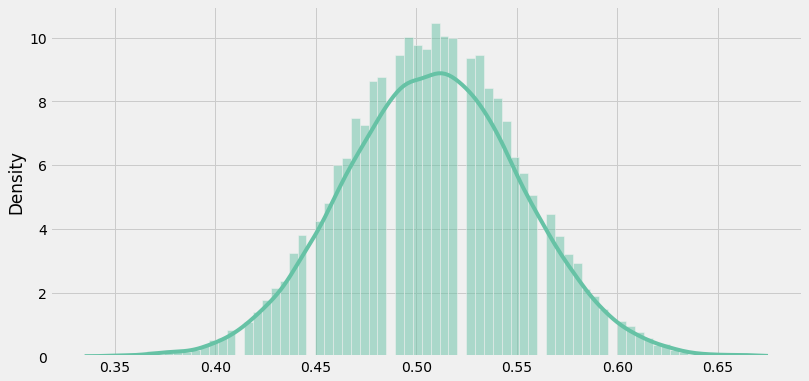

In [117]:
# Faccio l'encoding delle features categoriche, tipo il mese
encoder = encoder_list[0]
df2_data = pd.DataFrame(np.ones(shape=(len(X2)))*data_img.month,columns=['mese'])
X2_data = encoder.transform(df2_data)

# # Modello NN
try:
    y2 = best_model.predict(X2, verbose = 1)
    y2 = y2[:,0]
    print("Modello Neural Network")
except:
    pass

# # Modello NN con mesi
try:
    y2 = best_model.predict([X2, X2_data], verbose = 1)
    y2 = y2[:,0]
    print("Modello Neural Network con dati extra")
except:
    pass

# # Modello Ensemble
try:
    y2 = best_model.predict_proba(X2.reshape((len(X2),-1)))
    y2 = y2[:,1]
    print("Modello Ensemble")
except:
    pass

y_df = pd.Series(y2)
sns.histplot(data=y_df, kde=True, stat="density")
y_df.describe()

In [118]:
if os.path.split(data_path)[-1] == 'COPERNICUS_S2':
    ##### Layer nuvolosità
    plt.figure(figsize=(10,10))
    plt.imshow((data_raw[bands.index('QA60')]/1024).astype(int), interpolation='none')
    plt.colorbar()
    plt.show()
    ##### Layer B10 SWIR Cirrus
    plt.figure(figsize=(10,10))
    plt.imshow((data_raw[bands.index('B10')]/10 - 1).astype(int), interpolation='none')
    plt.colorbar()
    plt.show()
elif os.path.split(data_path)[-1] == 'COPERNICUS_S2_SR':
    ##### Layer nuvolosità
    plt.figure(figsize=(10,10))
    plt.imshow((data_raw[bands.index('QA60')]/1024).astype(int), interpolation='none')
    plt.colorbar()
    plt.show()
    ##### Layer SCL Scene Classifier Layer - dettaglio del tipo di cella 20x20m
    plt.figure(figsize=(10,10))
#     cloud_low_prob = np.where(data_raw[bands.index('SCL')].astype(int)==7,1,0)
#     cloud_medium_prob = np.where(data_raw[bands.index('SCL')].astype(int)==8,1,0)
#     cloud_high_prob = np.where(data_raw[bands.index('SCL')].astype(int)==9,1,0)
#     cirrus = np.where(data_raw[bands.index('SCL')].astype(int)==10,1,0)
    plt.imshow((np.where(data_raw[bands.index('SCL')]>=7,1,0)), interpolation='none')
    plt.colorbar()
    plt.show()

In [119]:
# # now put into pic
imr = np.ones_like(data)*-999
imr = imr[0].T
imr[ppcs[:,0],ppcs[:,1]] = y2

imr = np.ma.masked_where(imr == -999,imr)
imr = imr.T[::-1]

####### tolgo i risultati dove era nuvoloso
if os.path.split(data_path)[-1] == 'COPERNICUS_S2':
    cloud_matrix = (((data_raw[-1] >= 1024)-1)**2) #np.where(data_raw[bands.index('SCL')] >= 1024,0,1)
    cloud_matrix = (((data_raw[-2] >= 2048)-1)**2) #np.where(data_raw[bands.index('SCL')] >= 2048,0,1)
    imr = imr * cloud_matrix
if os.path.split(data_path)[-1] == 'COPERNICUS_S2_SR':
    cloud_matrix = np.where(data_raw[bands.index('QA60')] >= 1024,0,1)
    cloud_matrix = np.where(data_raw[bands.index('SCL')] >= 7,0,1)
    imr = imr * cloud_matrix

####### tolgo i risultati dei bordi dell'immagine
border_matrix = np.zeros(shape=imr.shape)
border_matrix[padding:-padding,padding:-padding] = 1
imr = imr * border_matrix
imr = np.ma.masked_where(imr == 0, imr)

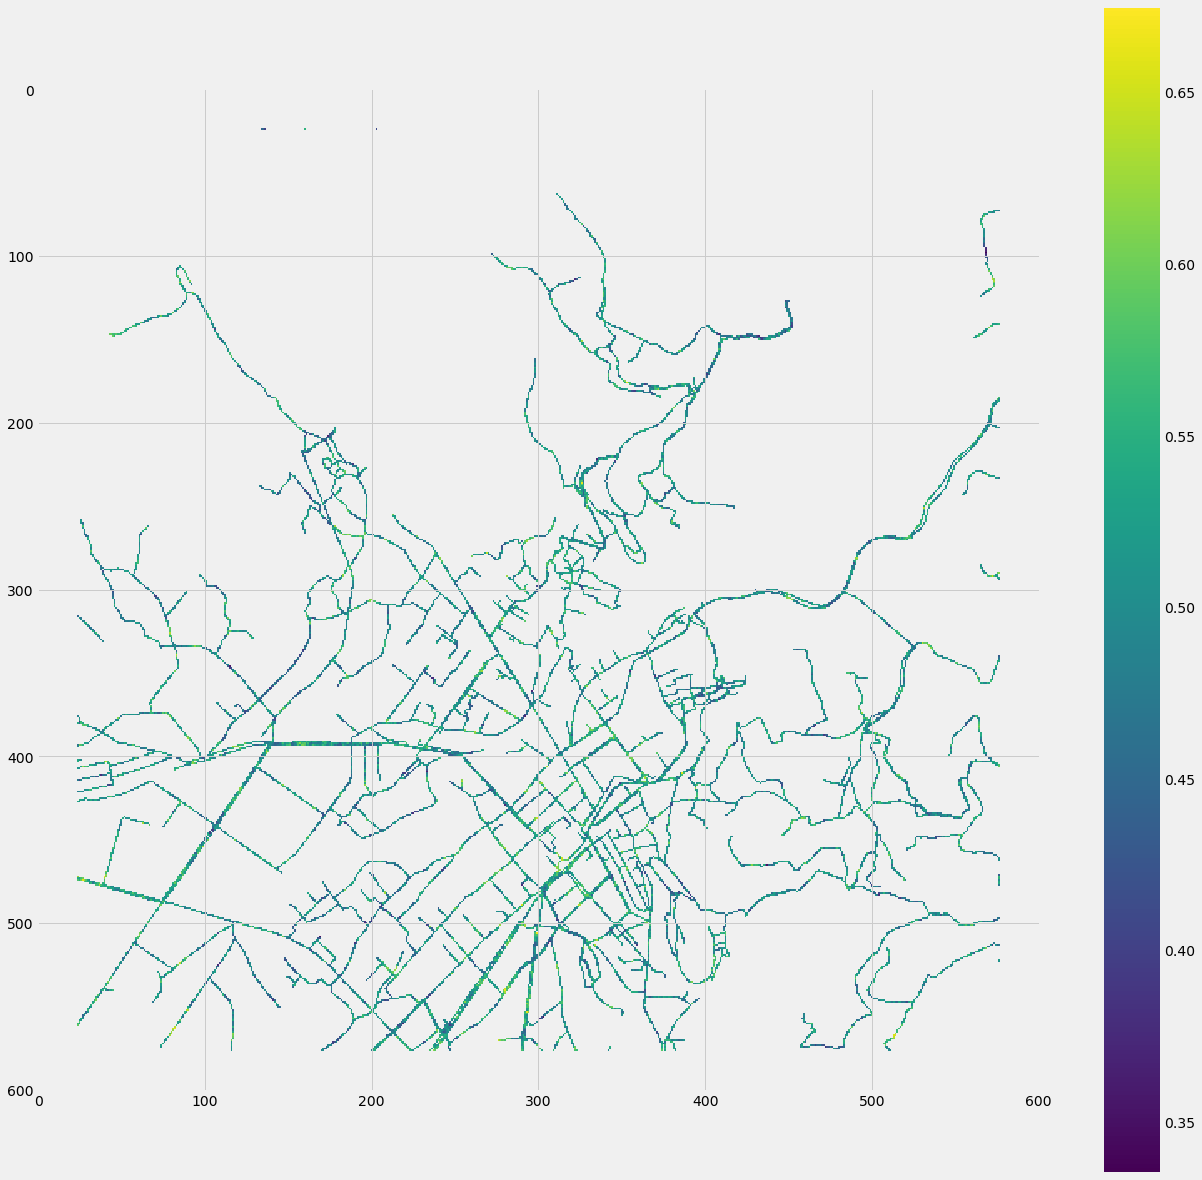

In [120]:
# just the ones with high confidence
y_avg = y_df.describe()[1]
y_min = y_df.describe()[3]
y_max = y_df.describe()[7]
y_25 = y_df.describe()[4]
y_75 = y_df.describe()[6]

plt.figure(figsize=(20,20))
plt.imshow(imr, interpolation='none', vmin=y_min, vmax=y_max)
plt.colorbar()
plt.show()

## Folium map of prediction

In [121]:
import folium
from folium import plugins
from folium import raster_layers

im_sat = im_sat
im_pipe = imr

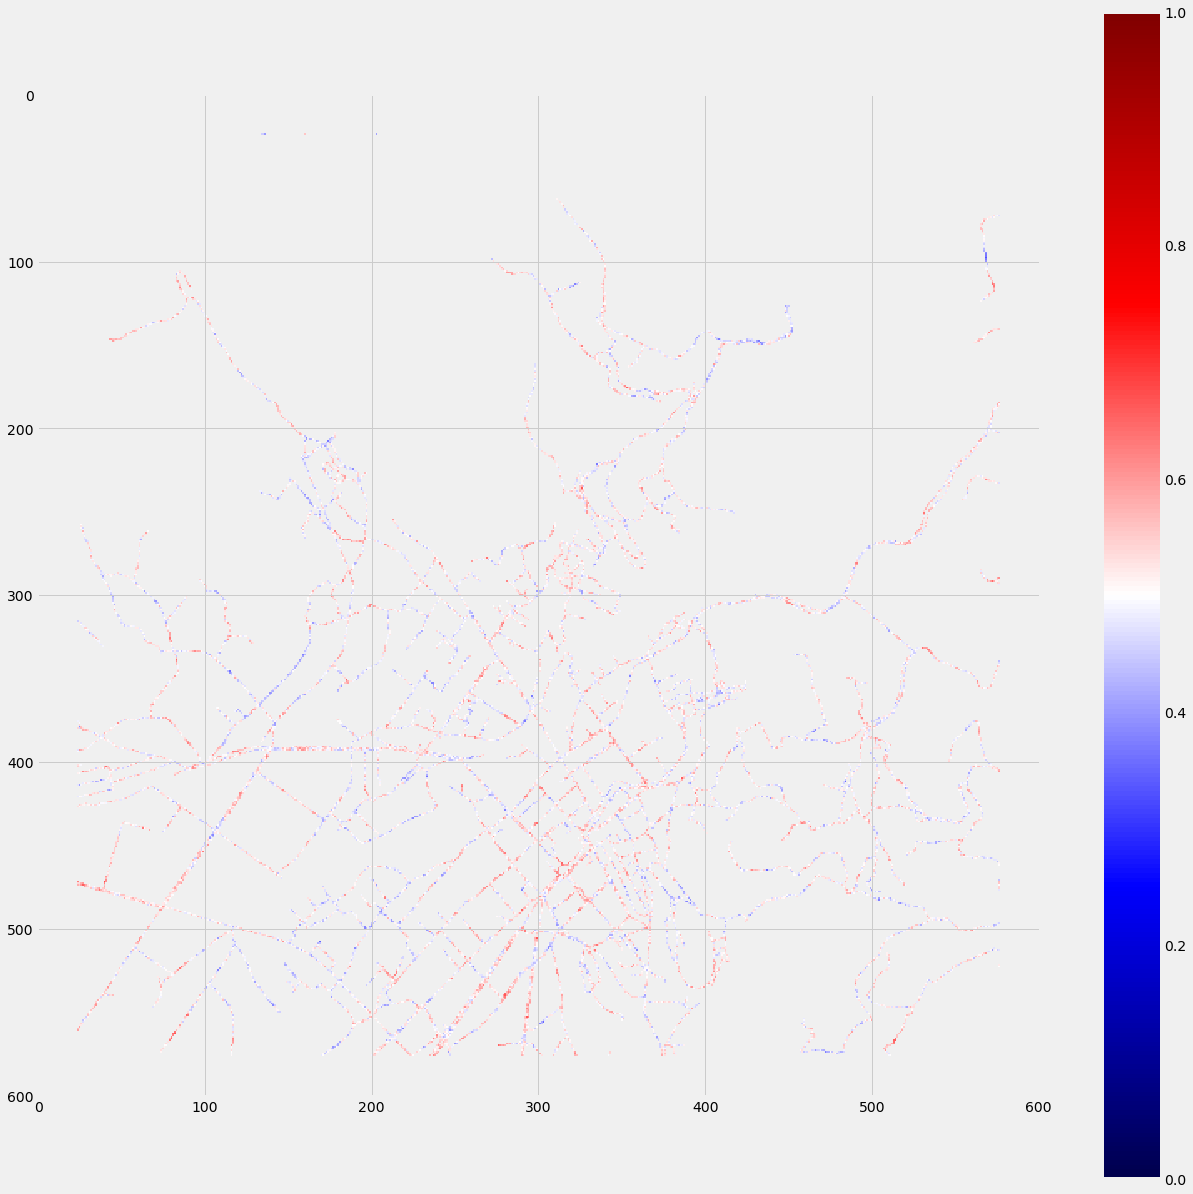

In [122]:
plt.figure(figsize=(20,20))
plt.imshow(im_pipe, interpolation='none', cmap='seismic', vmin=0, vmax=1)
plt.colorbar()
plt.show()

### Plot

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


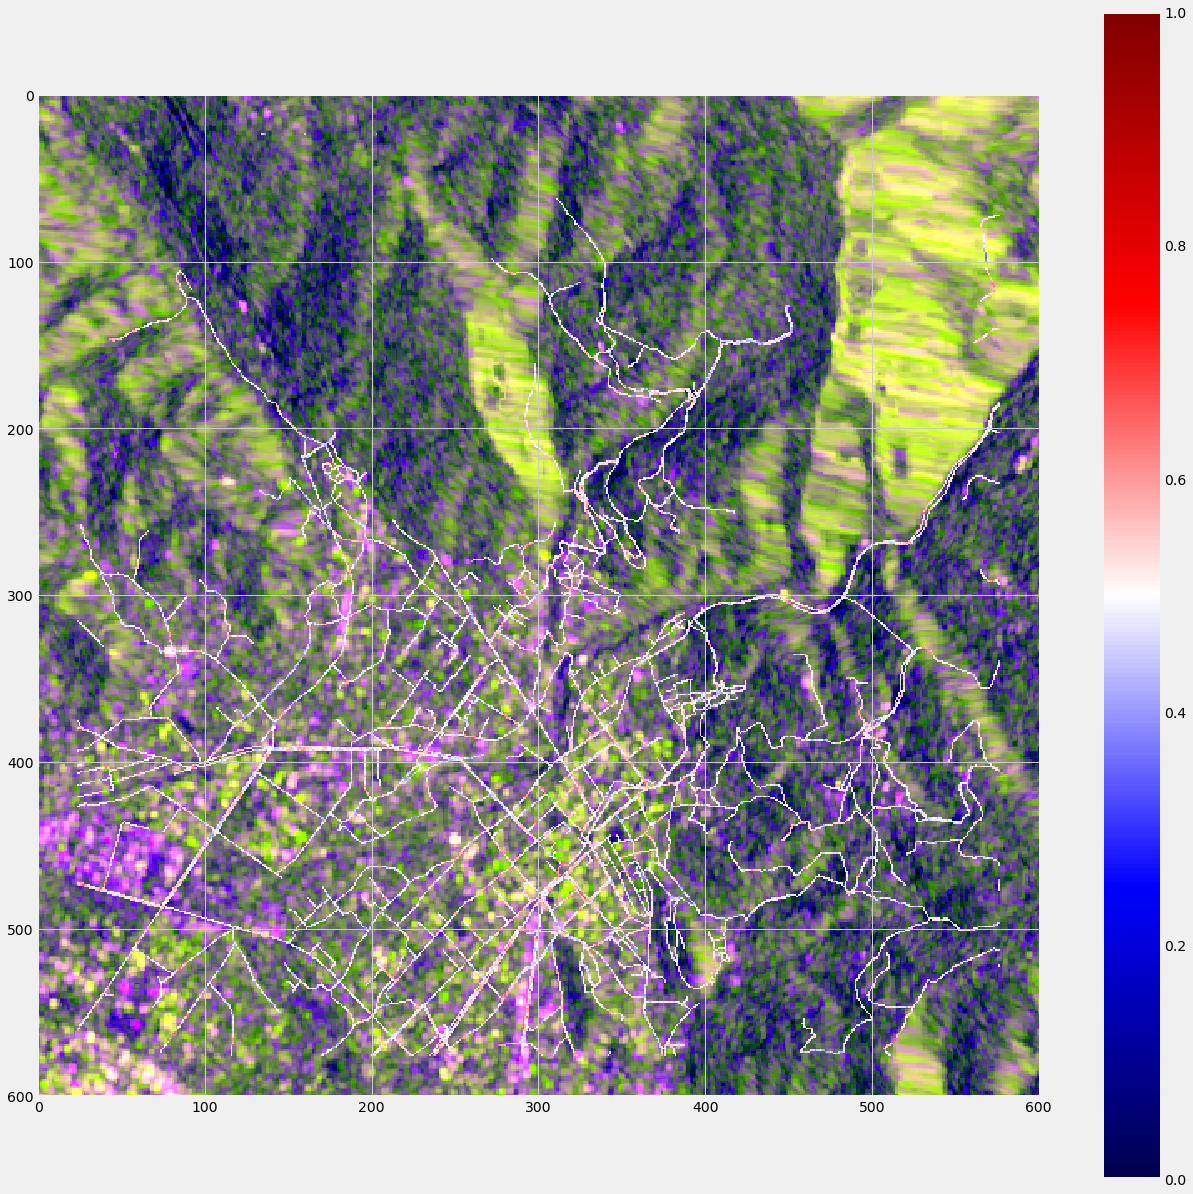

In [123]:
plt.figure(figsize=(20,20))
plt.imshow(im_sat, interpolation='none')
plt.imshow(im_pipe, interpolation='none', cmap='seismic', vmin=0, vmax=1)
plt.colorbar()

#plt.savefig(outdir.joinpath('heatmap_'+nome_punto+'.png'))
plt.show()

### Save as GeoTiff for putting into QGIS

In [124]:
# Calcolo i parametri di trasformazione
# get image size and location
import rasterio

ref_file = path+'\\'+files[0]
print("File di riferimento:",ref_file)
tiff_rif = rasterio.open(ref_file)

# write GeoTiff
outfile = outdir.joinpath('heatmap_'+nome_punto+'.tiff')
Z=im_pipe.astype('float32')

with rasterio.open(
        outfile,
        'w',
        driver='GTiff',
        height=Z.shape[0],
        width=Z.shape[1],
        count=1,
        dtype=Z.dtype,
        crs=tiff_rif.crs,
        transform=tiff_rif.transform
    ) as dest:
    dest.write(Z, 1)

outfile

File di riferimento: ..\output\temp\20220402-05-27-47_3857_10.0\download.slope.tif


Path('../output\\leak_detection_CNN\\COPERNICUS_S1_GRD\\heatmap_MASSA CENTRO.tiff')